In Part 4 we'll use the following strategy:

-) We'll use year 2021 for cross-validation and hyperparameters tuning. We'll break the data from this year into tuning and cross-validation parts.

-) After each step, we'll subtract the predictions made in this step from the target, making the residues to be a new target for the next step. This way we'll make sure we avoid leakage.

Let's load the datasets:

In [311]:
%%time

import pandas as pd
import numpy as np

## Use the same random state integer as in previous parts
global_variables = pd.read_csv('global_variables.csv', index_col=0)
SEED = global_variables.loc[0, 'SEED']

unprocessed_train_full = pd.read_csv('datasets/train.csv', index_col='ID_LAT_LON_YEAR_WEEK')
unprocessed_test = pd.read_csv('datasets/test.csv', index_col='ID_LAT_LON_YEAR_WEEK')

unprocessed_train_full.head()

CPU times: total: 844 ms
Wall time: 897 ms


latitude  longitude  year  week_no  \
ID_LAT_LON_YEAR_WEEK                                           
ID_-0.510_29.290_2019_00     -0.51      29.29  2019        0   
ID_-0.510_29.290_2019_01     -0.51      29.29  2019        1   
ID_-0.510_29.290_2019_02     -0.51      29.29  2019        2   
ID_-0.510_29.290_2019_03     -0.51      29.29  2019        3   
ID_-0.510_29.290_2019_04     -0.51      29.29  2019        4   

                          SulphurDioxide_SO2_column_number_density  \
ID_LAT_LON_YEAR_WEEK                                                 
ID_-0.510_29.290_2019_00                                 -0.000108   
ID_-0.510_29.290_2019_01                                  0.000021   
ID_-0.510_29.290_2019_02                                  0.000514   
ID_-0.510_29.290_2019_03                                       NaN   
ID_-0.510_29.290_2019_04                                 -0.000079   

                          SulphurDioxide_SO2_column_number_density_amf  \
ID_LAT_LON_YEAR_WEEK                                                     
ID_-0.510_29.290_2019_00                                      0.603019   
ID_-0.510_29.290_2019_01                                      0.728214   
ID_-0.510_29.290_2019_02                                      0.748199   
ID_-0.510_29.290_2019_03                                           NaN   
ID_-0.510_29.290_2019_04                                      0.676296   

                          SulphurDioxide_SO2_slant_column_number_density  \
ID_LAT_LON_YEAR_WEEK                                                       
ID_-0.510_29.290_2019_00                                       -0.000065   
ID_-0.510_29.290_2019_01                                        0.000014   
ID_-0.510_29.290_2019_02                                        0.000385   
ID_-0.510_29.290_2019_03                                             NaN   
ID_-0.510_29.290_2019_04                                       -0.000048   

                          SulphurDioxide_cloud_fraction  \
ID_LAT_LON_YEAR_WEEK                                      
ID_-0.510_29.290_2019_00                       0.255668   
ID_-0.510_29.290_2019_01                       0.130988   
ID_-0.510_29.290_2019_02                       0.110018   
ID_-0.510_29.290_2019_03                            NaN   
ID_-0.510_29.290_2019_04                       0.121164   

                          SulphurDioxide_sensor_azimuth_angle  \
ID_LAT_LON_YEAR_WEEK                                            
ID_-0.510_29.290_2019_00                           -98.593887   
ID_-0.510_29.290_2019_01                            16.592861   
ID_-0.510_29.290_2019_02                            72.795837   
ID_-0.510_29.290_2019_03                                  NaN   
ID_-0.510_29.290_2019_04                             4.121269   

                          SulphurDioxide_sensor_zenith_angle  ...  \
ID_LAT_LON_YEAR_WEEK                                          ...   
ID_-0.510_29.290_2019_00                           50.843559  ...   
ID_-0.510_29.290_2019_01                           39.137194  ...   
ID_-0.510_29.290_2019_02                           52.868816  ...   
ID_-0.510_29.290_2019_03                                 NaN  ...   
ID_-0.510_29.290_2019_04                           35.515587  ...   

                          Cloud_cloud_top_height  Cloud_cloud_base_pressure  \
ID_LAT_LON_YEAR_WEEK                                                          
ID_-0.510_29.290_2019_00             3664.436218               61085.809570   
ID_-0.510_29.290_2019_01             3651.190311               66969.478735   
ID_-0.510_29.290_2019_02             4216.986492               60068.894448   
ID_-0.510_29.290_2019_03             5228.507736               51064.547339   
ID_-0.510_29.290_2019_04             3980.598120               63751.125781   

                          Cloud_cloud_base_height  Cloud_cloud_optical_depth  \
ID_LAT_LON_YEAR_WEEK                          

## Breaking the data into train, tuning and cross-validation sets

In [312]:
%%time

# Create WeekCount feature (a number of a week in the whole period)

feature_name = 'WeekCount'
for data in [unprocessed_train_full, unprocessed_test]:
    
    data['WeekCount'] = (data['year'] - 2019) * 53 + data['week_no']
    
# Create a 'date' feature
feature_name = 'date'
for data in [unprocessed_train_full, unprocessed_test]:
    
    data['date'] = pd.to_datetime(data.year.astype(str), format='%Y') + \
                     pd.to_timedelta(data.week_no.mul(7).astype(str) + ' days')

# Create the training set (2019-2020)
unprocessed_train = unprocessed_train_full.loc[unprocessed_train_full['year'] < 2021, :].copy(deep=True)

# Create the tuning set (2021, first half)
unprocessed_tuning = unprocessed_train_full.loc[(unprocessed_train_full['year'] == 2021) &
                                                (unprocessed_train_full['week_no'] < 53 / 2), :].copy(deep=True)

# Create the cross-validation set (2021, second half)
unprocessed_cv = unprocessed_train_full.loc[(unprocessed_train_full['year'] == 2021) &
                                                (unprocessed_train_full['week_no'] >= 53 / 2), :].copy(deep=True)

# Create the DataFrames with target variables
y_train = unprocessed_train[['latitude', 'longitude', 'year', 'week_no', 'WeekCount', 'date', 'emission']].copy(deep=True)
y_tuning = unprocessed_tuning[['latitude', 'longitude', 'year', 'week_no', 'WeekCount', 'date', 'emission']].copy(deep=True)
y_cv = unprocessed_cv[['latitude', 'longitude',  'year', 'week_no', 'WeekCount', 'date', 'emission']].copy(deep=True)
y_test = unprocessed_test[['latitude', 'longitude', 'year', 'week_no', 'WeekCount', 'date']].copy(deep=True)



# Create the scores DataFrame
scores_df = pd.DataFrame({'Comment': [], 'Train RMSE': [], 'Tuning RMSE': [], 'Cross-val RMSE': [], 'Test RMSE': []})

CPU times: total: 266 ms
Wall time: 291 ms


## 00. Using only the satellite data

First, we'll try to predict 'emission' using the satellite data only:

In [313]:
%%time

study_number = '00'

scores_df.loc[int(study_number), 'Comment'] = 'Satellite'
                
# UNCOMMENT TO INSTALL LightGBM
#!pip install lightgbm
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

# Instantiate the estimator
model = lgb.LGBMRegressor(random_state=SEED, n_jobs=-1)

# Isolate the satellite data
train = unprocessed_train.drop(['latitude', 'longitude', 'year', 'week_no', 'WeekCount', 'date', 'emission'], axis=1)
tuning = unprocessed_tuning.drop(['latitude', 'longitude', 'year', 'week_no', 'WeekCount', 'date', 'emission'], axis=1)
cv = unprocessed_cv.drop(['latitude', 'longitude', 'year', 'week_no', 'WeekCount', 'date', 'emission'], axis=1)
test = unprocessed_test.drop(['latitude', 'longitude', 'year', 'week_no', 'WeekCount', 'date'], axis=1)

# Fit
model.fit(train, y_train['emission'])

# Predict
y_train['pred_{}'.format(study_number)] = model.predict(train)
y_tuning['pred_{}'.format(study_number)] = model.predict(tuning)
y_cv['pred_{}'.format(study_number)] = model.predict(cv)

# Calculate RMSEs
scores_df.loc[int(study_number), 'Train RMSE'] = mean_squared_error(y_train['emission'], 
                                                                    y_train['pred_{}'.format(study_number)],
                                                                   squared=False)
scores_df.loc[int(study_number), 'Tuning RMSE'] = mean_squared_error(y_tuning['emission'], 
                                                                    y_tuning['pred_{}'.format(study_number)],
                                                                   squared=False)
scores_df.loc[int(study_number), 'Cross-val RMSE'] = mean_squared_error(y_cv['emission'], 
                                                                    y_cv['pred_{}'.format(study_number)],
                                                                   squared=False)

# Fit for the test (submission)
train_tuning_cv = pd.concat([train, tuning, cv]).copy(deep=True)
y_train_tuning_cv = pd.concat([y_train, y_tuning, y_cv]).copy(deep=True)
model.fit(train_tuning_cv, y_train_tuning_cv['emission'])

# Predict for the test (sumbission)
y_test['pred_{}'.format(study_number)] = model.predict(test)

# Create a submission file 
submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test.index, \
                           'emission': y_test['pred_{}'.format(study_number)]})

submission.to_csv('submissions/submission_4_' + study_number + '.csv', index=False)

CPU times: total: 15.5 s
Wall time: 1.58 s


In [314]:
scores_df.loc[int(study_number), 'Test RMSE'] = np.nan
scores_df

Comment  Train RMSE  Tuning RMSE  Cross-val RMSE  Test RMSE
0  Satellite  118.798737   150.423002      140.329189        NaN

## 00. Using only the satellite data, tuned

Now, we'll try perform a hyperparameters tuning on our model. As in the previous parts, all the tuning will be done in separate files. In this case, it will be ['studies/4_00.py']('studies/4_00.py').

In [315]:
%%time

study_number = '01'

scores_df.loc[int(study_number), 'Comment'] = '+ tuned'

# Save the datasets for tuning
train.to_csv('new_datasets/train_4_{}.csv'.format(study_number))
tuning.to_csv('new_datasets/tuning_4_{}.csv'.format(study_number))
y_train['emission'].to_csv('new_datasets/y_train_4_{}.csv'.format(study_number))
y_tuning['emission'].to_csv('new_datasets/y_tuning_4_{}.csv'.format(study_number))

CPU times: total: 4.27 s
Wall time: 4.7 s


In [316]:
import pickle

with open('studies/4_' + study_number + '_params.pkl', 'rb') as f:
    best_params = pickle.load(f)
    
print("Best hyperparameters:", best_params)

Best hyperparameters: {'num_leaves': 70, 'max_depth': 18, 'learning_rate': 0.03645032343081469, 'n_estimators': 270, 'min_child_weight': 108.24480109932279, 'min_child_samples': 40, 'subsample': 0.95, 'subsample_freq': 20, 'colsample_bytree': 0.6, 'reg_alpha': 0.05865540122280832, 'reg_lambda': 0.23283145567987615}


In [317]:
%%time

# Instantiate the estimator
model = lgb.LGBMRegressor(random_state=SEED, n_jobs=-1, **best_params)

# Fit
model.fit(train, y_train['emission'])

# Predict
y_train['pred_{}'.format(study_number)] = model.predict(train)
y_tuning['pred_{}'.format(study_number)] = model.predict(tuning)
y_cv['pred_{}'.format(study_number)] = model.predict(cv)

# Calculate RMSEs
scores_df.loc[int(study_number), 'Train RMSE'] = mean_squared_error(y_train['emission'], 
                                                                    y_train['pred_{}'.format(study_number)],
                                                                   squared=False)
scores_df.loc[int(study_number), 'Tuning RMSE'] = mean_squared_error(y_tuning['emission'], 
                                                                    y_tuning['pred_{}'.format(study_number)],
                                                                   squared=False)
scores_df.loc[int(study_number), 'Cross-val RMSE'] = mean_squared_error(y_cv['emission'], 
                                                                    y_cv['pred_{}'.format(study_number)],
                                                                   squared=False)

# Fit for the test (submission)
train_tuning_cv = pd.concat([train, tuning, cv])
y_train_tuning_cv = pd.concat([y_train, y_tuning, y_cv])
model.fit(train_tuning_cv, y_train_tuning_cv['emission'])

# Predict for the test (sumbission)
y_train_tuning_cv['pred_{}'.format(study_number)] = model.predict(train_tuning_cv)
y_test['pred_{}'.format(study_number)] = model.predict(test)

# Create a submission file 
submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test.index, \
                           'emission': y_test['pred_{}'.format(study_number)]})

submission.to_csv('submissions/submission_4_' + study_number + '.csv', index=False)

CPU times: total: 1min 2s
Wall time: 6.74 s


In [318]:
scores_df.loc[int(study_number), 'Test RMSE'] = 167.7199
scores_df

Comment  Train RMSE  Tuning RMSE  Cross-val RMSE  Test RMSE
0  Satellite  118.798737   150.423002      140.329189        NaN
1    + tuned  117.365430   148.872404      139.874068   167.7199

A small improvement. Now, we'll subtract predictions from 'emission' to create a new target:

In [319]:
y_train['emission_{}'.format(study_number)] = y_train['emission'] - y_train['pred_{}'.format(study_number)]
y_tuning['emission_{}'.format(study_number)] = y_tuning['emission'] - y_tuning['pred_{}'.format(study_number)]
y_cv['emission_{}'.format(study_number)] = y_cv['emission'] - y_cv['pred_{}'.format(study_number)]
y_train_tuning_cv['emission_{}'.format(study_number)] = y_train_tuning_cv['emission'] -\
    y_train_tuning_cv['pred_{}'.format(study_number)]

## Creating location groups

For the next step, we need to create groups of locations with common emission patterns, to analyze and transform each group separately:

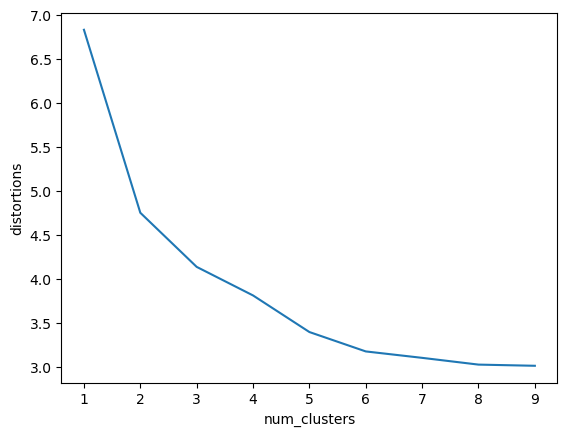

CPU times: total: 2.17 s
Wall time: 826 ms


In [320]:
%%time

from sklearn.preprocessing import StandardScaler
from scipy.cluster.vq import kmeans, vq
import matplotlib.pyplot as plt
import seaborn as sns

# Create a Location feature

feature_name = 'Location'

for data in [unprocessed_train, unprocessed_tuning, unprocessed_cv, unprocessed_test,
             y_train, y_tuning, y_cv, y_test, y_train_tuning_cv]:
    data[feature_name] = data['latitude'].astype('string') + data['longitude'].astype('string')

## Create a pivot table of emssions by date and location
location_table = pd.pivot_table(y_train_tuning_cv, columns='date', index='Location', values='emission_01')


# Normalize data
location_table = pd.DataFrame(StandardScaler().fit_transform(location_table),
                            columns=location_table.columns,
                           index=location_table.index)

distortions = []
num_clusters = range(1, 10)

# Create a list of distortions from the kmeans function
for i in num_clusters:
    cluster_centers, distortion = kmeans(location_table, k_or_guess=i, seed=SEED)
    distortions.append(distortion)

# Create a DataFrame with two lists - num_clusters, distortions
elbow_plot = pd.DataFrame({'num_clusters': num_clusters, 'distortions': distortions})

# Creat a line plot of num_clusters and distortions
sns.lineplot(x='num_clusters', y='distortions', data = elbow_plot)
plt.xticks(num_clusters)
plt.show()

We'll use 5 clusters:

In [321]:
%%time

cluster_centers, distortion = kmeans(location_table, k_or_guess=5, seed=SEED)


# Assign cluster labels
cluster_labels, _ = vq(location_table, cluster_centers)
cluster_dictionary = dict(zip(location_table.index, cluster_labels))


for data in [unprocessed_train, unprocessed_tuning, unprocessed_cv, unprocessed_test,
             y_train, y_tuning, y_cv, y_test, y_train_tuning_cv]:
    data['Group'] = data["Location"].map(cluster_dictionary)

CPU times: total: 250 ms
Wall time: 91.6 ms


<timed exec>:2: FutureWarning: The operation <function mean at 0x00000213B3F76320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.


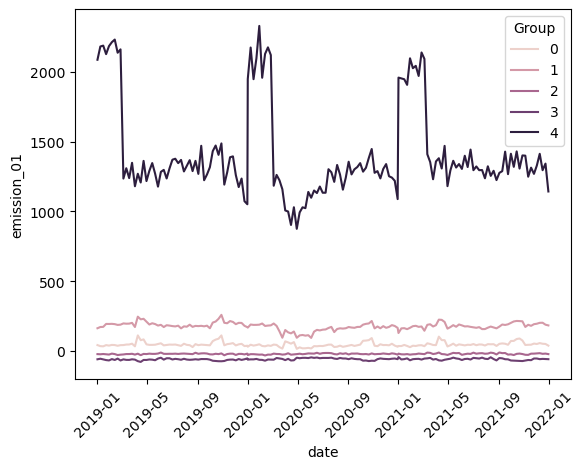

CPU times: total: 516 ms
Wall time: 272 ms


In [322]:
%%time

# Group by Group and date
y_train_tuning_cv_grouped = y_train_tuning_cv.groupby(['Group', 'date']).agg(np.mean)

fig, ax = plt.subplots()
sns.lineplot(data=y_train_tuning_cv_grouped, x='date', y='emission_01', hue='Group')
plt.xticks(rotation=45)
plt.show()

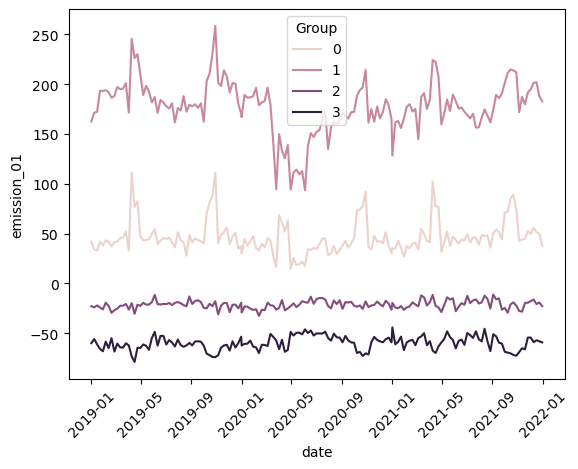

CPU times: total: 219 ms
Wall time: 261 ms


In [323]:
%%time

fig, ax = plt.subplots()
sns.lineplot(data=y_train_tuning_cv_grouped[y_train_tuning_cv_grouped.index.get_level_values('Group') < 4],
             x='date', y='emission_01', hue='Group')
plt.xticks(rotation=45)
plt.show()

## 02. Trend

Detrending this data is tricky, because the trend was distorted by the COVID lockdown in 2020 (as noted by AmbrosM).

Here are the mean emissions among all locations:

<timed exec>:6: FutureWarning: The operation <function mean at 0x00000213B3F76320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.


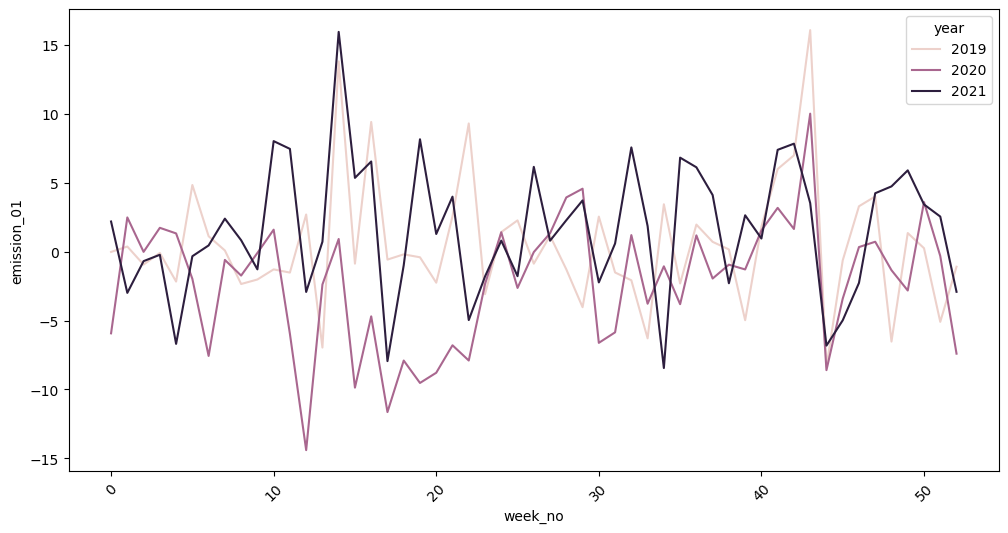

CPU times: total: 172 ms
Wall time: 182 ms


In [324]:
%%time

study_number = '02'

scores_df.loc[int(study_number), 'Comment'] = 'Trend'

# Group by  date
y_train_tuning_cv_grouped = y_train_tuning_cv.groupby(['year', 'date']).agg(np.mean)

fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=y_train_tuning_cv_grouped, x='week_no', y='emission_01', hue='year')
plt.xticks(rotation=45)
plt.show()

Let's look at the differences between 2020 and averages of the other two years:

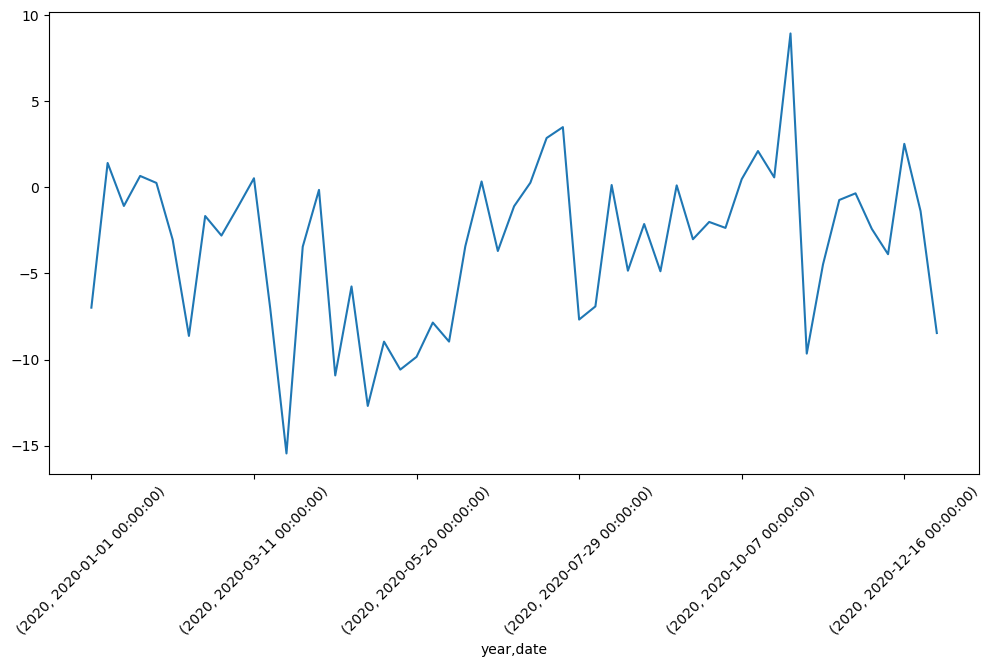

In [325]:
difference_2020 = y_train_tuning_cv_grouped.loc[y_train_tuning_cv_grouped.index.get_level_values('year') == 2020,
                                                'emission_01'] -\
                    y_train_tuning_cv_grouped.loc[y_train_tuning_cv_grouped.index.get_level_values('year') != 2020,
                                                  'emission_01'].mean()
fig, ax = plt.subplots(figsize=(12, 6))
difference_2020.plot()
plt.xticks(rotation=45)
plt.show()

In [326]:
difference_2020.sort_values()

year  date      
2020  2020-03-25   -15.457084
      2020-04-29   -12.697267
      2020-04-15   -10.922876
      2020-05-13   -10.584949
      2020-05-20    -9.844140
      2020-11-04    -9.654744
      2020-05-06    -8.959644
      2020-06-03    -8.957507
      2020-02-12    -8.626637
      2020-12-30    -8.460499
      2020-05-27    -7.852473
      2020-07-29    -7.676410
      2020-03-18    -7.023510
      2020-01-01    -6.985587
      2020-08-05    -6.913451
      2020-04-22    -5.753796
      2020-09-02    -4.871147
      2020-08-19    -4.838385
      2020-11-11    -4.472365
      2020-12-09    -3.879652
      2020-06-24    -3.693554
      2020-04-01    -3.443605
      2020-06-10    -3.416410
      2020-02-05    -3.034351
      2020-09-16    -3.010832
      2020-02-26    -2.796386
      2020-12-02    -2.406933
      2020-09-30    -2.351614
      2020-08-26    -2.125874
      2020-09-23    -2.005109
      2020-02-19    -1.660988
      2020-12-23    -1.376769
      2020-03-04    -1.

Even though it is unclear, let's assume that the lockdown drop started at 2020-03-11. We'll calculate trend for dates before this date.

Then we'll assume that the lockdown drop peaked at 2020-04-29. We'll calculate a separate trend for the drop period.

Then we'll calculate a separate trend for the rest of the train data combined with tuning data and continue this trend on the cv data.

For the test, we'll calculate trend on post-drop train, cv and tuning data, and continue ths trend on the test data.

All trends will be linear.

In [327]:
%%time

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression

cv_weeks = len(y_cv['WeekCount'].unique())
test_weeks = len(y_test["WeekCount"].unique())

order=1

y_train_after_drop = y_train[y_train['date'] > pd.to_datetime('2020-04-29')]
y_train_after_drop_and_tuning = pd.concat([y_train_after_drop, y_tuning])
y_train_after_drop_tuning_and_cv = y_train_tuning_cv[y_train_tuning_cv['date'] >\
                                                     pd.to_datetime('2020-04-29')]


locations_count=0

for location in y_train['Location'].unique():
    
    # Save indices
    train_before_drop_index = y_train[(y_train['Location'] == location) & 
                                    (y_train['date'] < pd.to_datetime('2020-03-11'))].index
    train_drop_index = y_train[(y_train['Location'] == location) & 
                                    (y_train['date'] >= pd.to_datetime('2020-03-11')) &
                                    (y_train['date'] <= pd.to_datetime('2020-04-29'))].index
    train_after_drop_index = train[(y_train['Location'] == location) & 
                                    (y_train['date'] > pd.to_datetime('2020-04-29'))].index
    tuning_index = y_tuning[y_tuning["Location"] == location].index
    train_after_drop_and_tuning_index = y_train_after_drop_and_tuning[\
                y_train_after_drop_and_tuning["Location"] == location].index
    cv_index = y_cv[y_cv["Location"] == location].index
    train_after_drop_tuning_and_cv_index = y_train_after_drop_tuning_and_cv[\
                            y_train_after_drop_tuning_and_cv["Location"] == location].index
    test_index = y_test[y_test["Location"] == location].index

    #print('test')
    
    ## Calculate trends
    
    # Before drop
    series = pd.Series(y_train.loc[train_before_drop_index, 'emission_01'].values, \
                   index=y_train.loc[train_before_drop_index, 'date'])
        
    series.index = series.index.to_period('W')    
    
    dp = DeterministicProcess(index=series.index, constant=True, order=order, drop=True)
    X = dp.in_sample()

    lr = LinearRegression(fit_intercept=False)
    lr.fit(X, series)
    
    #print('test1')
    

    y_pred = pd.Series(lr.predict(X), index=train_before_drop_index)
    y_train.loc[train_before_drop_index, 'pred_{}'.format(study_number)] = y_pred
    y_train_tuning_cv.loc[train_before_drop_index, 'pred_{}'.format(study_number)] = y_pred
    
    
    # Drop period
    series = pd.Series(y_train.loc[train_drop_index, 'emission_01'].values, \
                   index=y_train.loc[train_drop_index, 'date'])
        
    series.index = series.index.to_period('W')    
    
    dp = DeterministicProcess(index=series.index, constant=True, order=order, drop=True)
    X = dp.in_sample()

    lr = LinearRegression(fit_intercept=False)
    lr.fit(X, series)
    
    
    

    y_pred = pd.Series(lr.predict(X), index=train_drop_index)
    y_train.loc[train_drop_index, 'pred_{}'.format(study_number)] = y_pred
    y_train_tuning_cv.loc[train_drop_index, 'pred_{}'.format(study_number)] = y_pred

    #print('test2')
    
    # After the drop (train) and tuning
    series = pd.Series(y_train_after_drop_and_tuning.loc[train_after_drop_and_tuning_index,
                                                         'emission_01'].values, \
                   index=y_train_after_drop_and_tuning.loc[train_after_drop_and_tuning_index, 'date'])
    

    series.index = series.index.to_period('W')    
    
    dp = DeterministicProcess(index=series.index, constant=True, order=order, drop=True)
    X = dp.in_sample()

    lr = LinearRegression(fit_intercept=False)
    lr.fit(X, series)
    
    #print('test3')
    

    y_pred = pd.Series(lr.predict(X), index=train_after_drop_and_tuning_index)
    y_train.loc[train_after_drop_index, 'pred_{}'.format(study_number)] =\
                                            y_pred[train_after_drop_index]
    y_tuning.loc[tuning_index, 'pred_{}'.format(study_number)] =\
                                            y_pred[tuning_index]
    
    #print('test4')
    
    
    ## Continue trend on the cv set:
    X = dp.out_of_sample(steps=cv_weeks)
    y_pred = pd.Series(lr.predict(X), index=cv_index)
    y_cv.loc[cv_index, 'pred_{}'.format(study_number)] = y_pred
    
    ## Calculate trend on train_after_drop_tuning_and_cv

    series = pd.Series(y_train_after_drop_tuning_and_cv.loc[train_after_drop_tuning_and_cv_index,
                                                            'emission_01'].values, \
                   index=y_train_after_drop_tuning_and_cv.loc[train_after_drop_tuning_and_cv_index,
                                                              'date'])
        
    series.index = series.index.to_period('W')    
    
   
    dp = DeterministicProcess(index=series.index, constant=True, order=order, drop=True)
    X = dp.in_sample()

    lr = LinearRegression(fit_intercept=False)
    lr.fit(X, series)

    y_pred = pd.Series(lr.predict(X), index=train_after_drop_tuning_and_cv_index)
    y_train_tuning_cv.loc[train_after_drop_tuning_and_cv_index, 
                      ['pred_{}'.format(study_number)]] = y_pred
    
    
    ## Continue trend on the test set:
    X = dp.out_of_sample(steps=test_weeks)
    y_pred = pd.Series(lr.predict(X), index=test_index)
    y_test.loc[test_index, 'pred_{}'.format(study_number)] = y_pred

    locations_count +=1
    #print(locations_count)



CPU times: total: 20.8 s
Wall time: 22.4 s


Let's look at the average trend: 

<timed exec>:7: FutureWarning: The operation <function mean at 0x00000213B3F76320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:8: FutureWarning: The operation <function mean at 0x00000213B3F76320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.


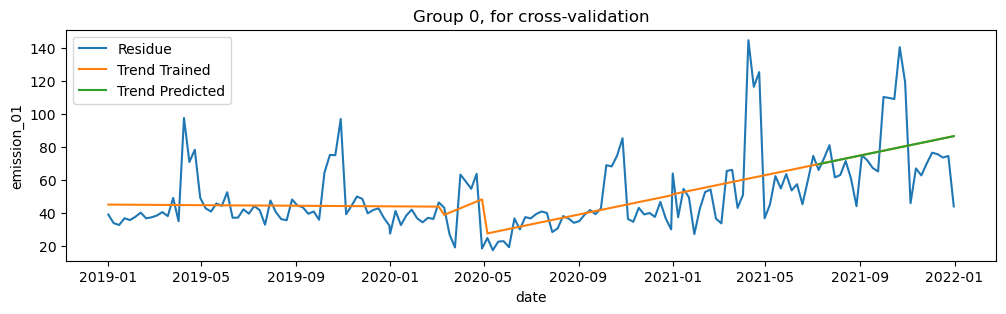

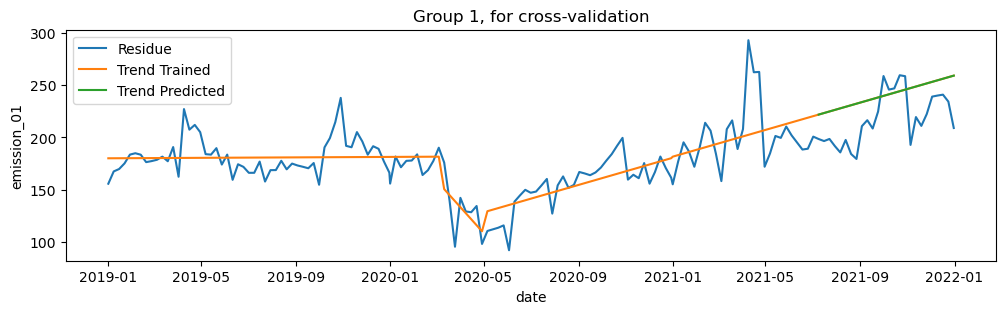

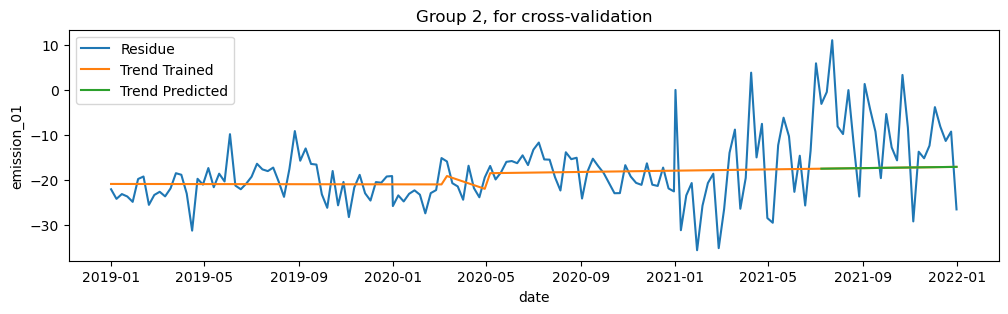

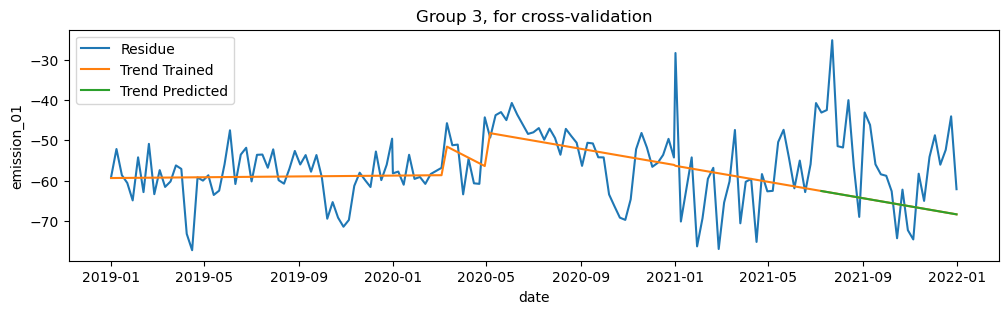

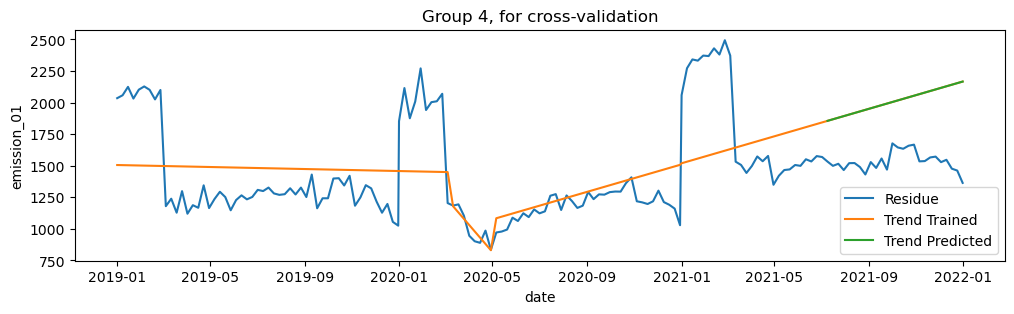

CPU times: total: 1.08 s
Wall time: 1.32 s


In [328]:
%%time

groups = [i for i in range(0, 5)]

y_train_tuning_cv_technical = pd.concat([y_train, y_tuning, y_cv])

# Group by Group and date
y_train_tuning_cv_technical_grouped = y_train_tuning_cv_technical.groupby(['Group',
                                                                           'date']).agg(np.mean)
y_cv_grouped = y_cv.groupby(['Group', 'date']).agg(np.mean)

for group in groups:
    fig, ax = plt.subplots(figsize=(12, 3))
    
    sns.lineplot(data = y_train_tuning_cv_technical_grouped[y_train_tuning_cv_technical_grouped.\
                                                            index.get_level_values(\
                'Group') == group], x='date', y='emission_01',
                 label='Residue').\
            set(title='Group {}, for cross-validation'.format(group))
    sns.lineplot(data = y_train_tuning_cv_technical_grouped[y_train_tuning_cv_technical_grouped.\
                                                            index.get_level_values(\
                'Group') == group], x='date', y='pred_{}'.format(study_number),
                 label='Trend Trained')
    sns.lineplot(data = y_cv_grouped[y_cv_grouped.index.get_level_values(\
                'Group') == group], x='date', y='pred_{}'.format(study_number),
                 label='Trend Predicted')

    plt.show()

<timed exec>:6: FutureWarning: The operation <function mean at 0x00000213B3F76320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
<timed exec>:7: FutureWarning: The operation <function mean at 0x00000213B3F76320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.


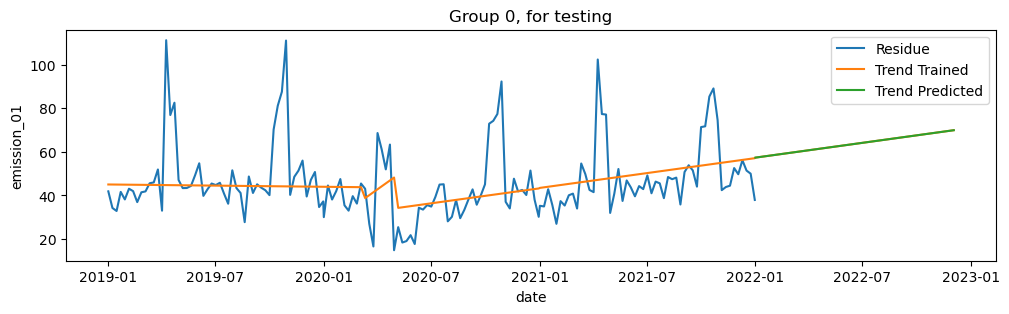

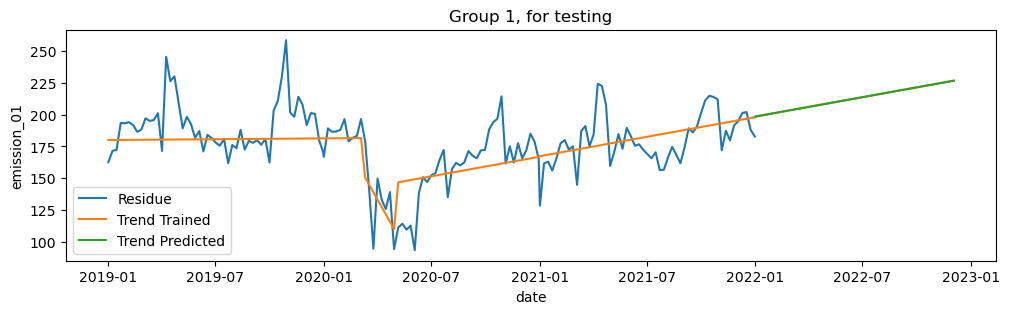

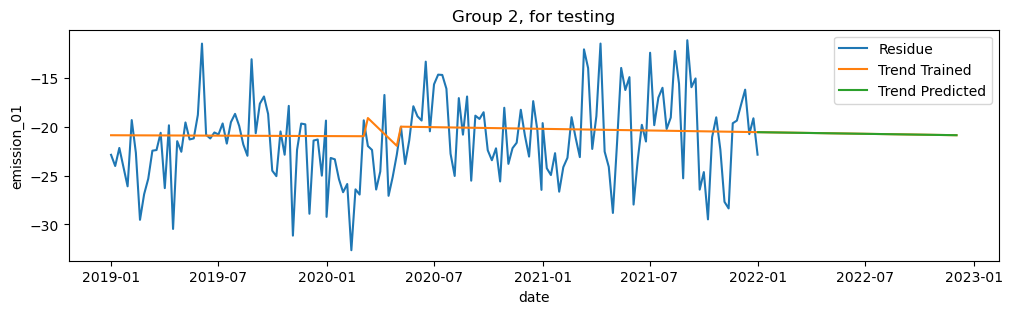

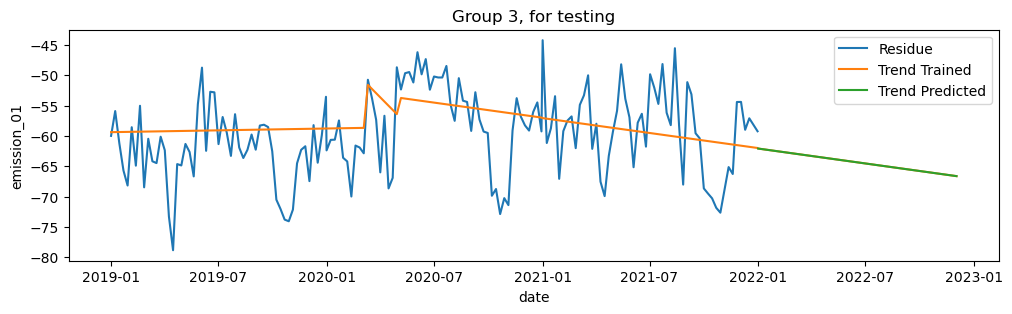

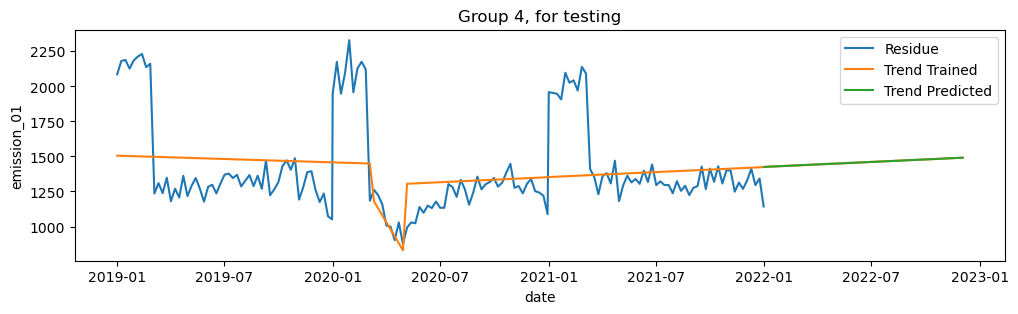

CPU times: total: 1.14 s
Wall time: 1.37 s


In [329]:
%%time

groups = [i for i in range(0, 5)]

y_train_tuning_cv_test = pd.concat([y_train_tuning_cv, y_test])

# Group by Group and date
y_train_tuning_cv_test_grouped = y_train_tuning_cv_test.groupby(['Group', 'date']).agg(np.mean)
y_test_grouped = y_test.groupby(['Group', 'date']).agg(np.mean)

for group in groups:
    fig, ax = plt.subplots(figsize=(12, 3))
    
    sns.lineplot(data = y_train_tuning_cv_test_grouped[y_train_tuning_cv_test_grouped.index.get_level_values(\
                'Group') == group], x='date', y='emission_01',
                 label='Residue').\
            set(title='Group {}, for testing'.format(group))
    sns.lineplot(data = y_train_tuning_cv_test_grouped[y_train_tuning_cv_test_grouped.index.get_level_values(\
                'Group') == group], x='date', y='pred_{}'.format(study_number),
                 label='Trend Trained')
    sns.lineplot(data = y_test_grouped[y_test_grouped.index.get_level_values(\
                'Group') == group], x='date', y='pred_{}'.format(study_number),
                 label='Trend Predicted')

    plt.show()

Now, we'll add predictions from studies 01 and 02 to calculate the scores:

In [330]:
pred_train = y_train['pred_02'] + y_train['pred_01']
scores_df.loc[int(study_number), 'Train RMSE'] = mean_squared_error(y_train['emission'], 
                                            pred_train, squared=False)
pred_tuning = y_tuning['pred_02'] + y_tuning['pred_01']
scores_df.loc[int(study_number), 'Tuning RMSE'] = mean_squared_error(y_tuning['emission'], 
                                            pred_tuning, squared=False)
pred_cv= y_cv['pred_02'] + y_cv['pred_01']
scores_df.loc[int(study_number), 'Cross-val RMSE'] = mean_squared_error(y_cv['emission'], 
                                            pred_cv, squared=False)
pred_test= y_test['pred_02'] + y_test['pred_01']
# Create a submission file 
submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test.index, \
                           'emission': pred_test})

submission.to_csv('submissions/submission_4_' + study_number + '.csv', index=False)

In [331]:
scores_df.loc[int(study_number), 'Test RMSE'] = np.nan
scores_df

Comment  Train RMSE  Tuning RMSE  Cross-val RMSE  Test RMSE
0  Satellite  118.798737   150.423002      140.329189        NaN
1    + tuned  117.365430   148.872404      139.874068   167.7199
2      Trend   38.582337    56.960628       52.020682        NaN

Let's create a new target:

In [332]:
y_train['emission_{}'.format(study_number)] = y_train['emission_{}'.\
        format('0' + str(int(study_number) -1))] - y_train['pred_{}'.format(study_number)]
y_tuning['emission_{}'.format(study_number)] = y_tuning['emission_{}'.\
        format('0' + str(int(study_number) -1))] - y_tuning['pred_{}'.format(study_number)]
y_cv['emission_{}'.format(study_number)] = y_cv['emission_{}'.\
        format('0' + str(int(study_number) -1))] - y_cv['pred_{}'.format(study_number)]
y_train_tuning_cv['emission_{}'.format(study_number)] = y_train_tuning_cv['emission_{}'.\
        format('0' + str(int(study_number) -1))] - y_train_tuning_cv['pred_{}'.format(study_number)]

## 03. Seasonality

For calculating seasonality, let's look at the periodograms of average emissions of the location groups:

Group: 0


<timed exec>:12: FutureWarning: The operation <function mean at 0x00000213B3F76320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
C:\Users\mikej\My Drive\5\Kaggle\CO2-Emissions\functions\plot_periodogram.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1W")


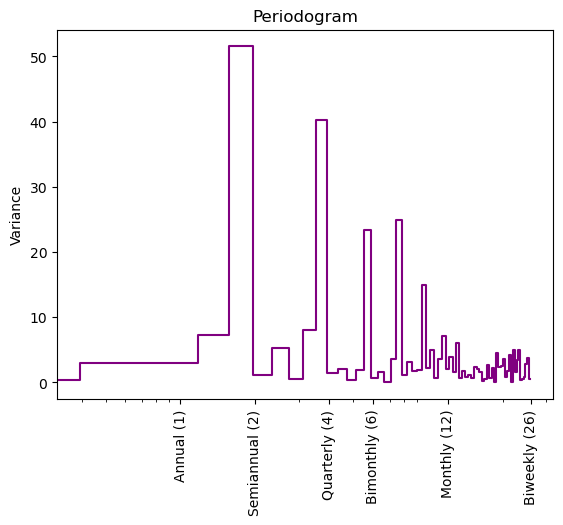

Group: 1


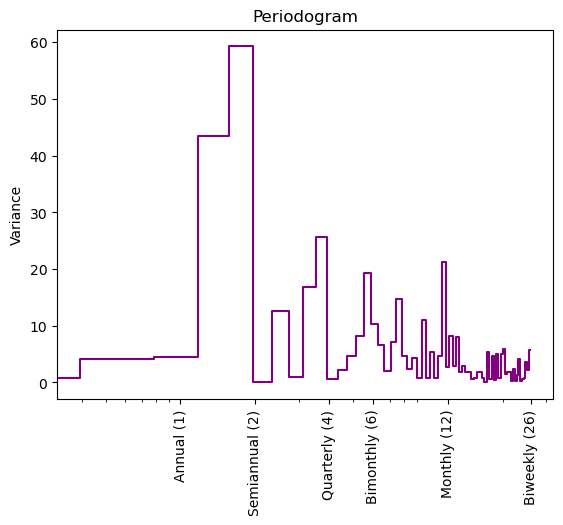

Group: 2


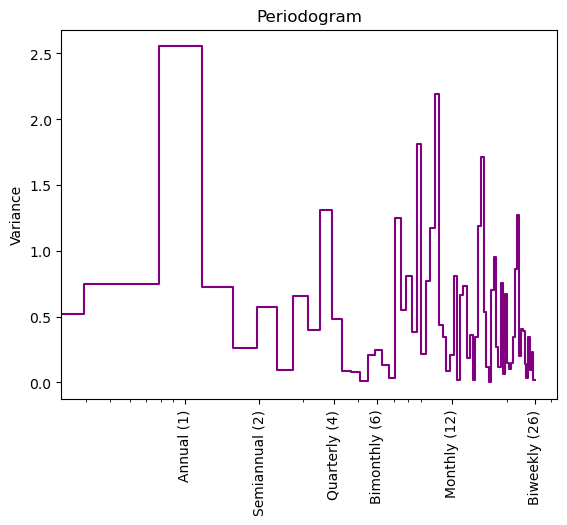

Group: 3


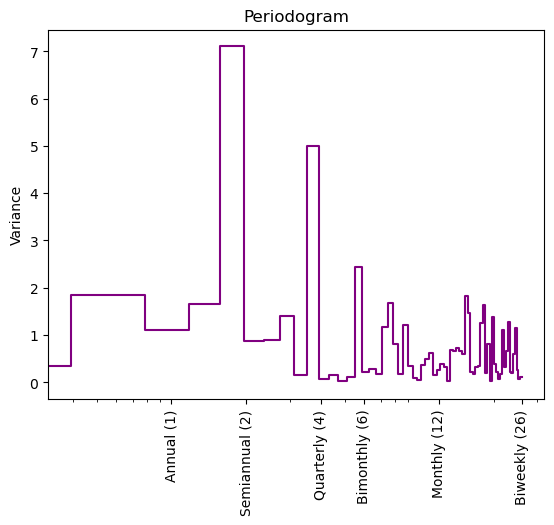

Group: 4


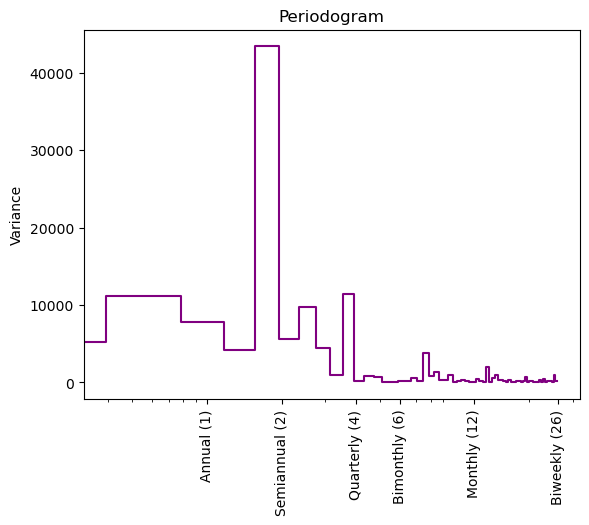

CPU times: total: 938 ms
Wall time: 1.22 s


In [333]:
%%time

study_number = '03'

scores_df.loc[int(study_number), 'Comment'] = '+ Seasonality'

from functions.plot_periodogram import plot_periodogram

#FOR CROSS-VALIDATION

y_train_tuning = pd.concat([y_train, y_tuning])

# Group by Group and date
y_train_tuning_grouped = y_train_tuning.groupby(['Group', 'date']).agg(np.mean)

for group in groups:
    print('Group: ' + str(group))
    
    series = pd.Series(y_train_tuning_grouped.loc[y_train_tuning_grouped.\
                    index.get_level_values('Group') == group,
                    'emission_{}'.format('0' + str(int(study_number) -1))].values, \
                    index=y_train_tuning_grouped.loc[y_train_tuning_grouped.\
                    index.get_level_values('Group') == group].index.get_level_values('date'))  
        
    series.index = series.index.to_period('W')
    plot_periodogram(series)
    plt.show()
    


Let's create a dictionary for our choise of number of Forier pairs and calculate Seasonality for cross-validation:

In [334]:
%%time

fourier_dict  = {0: 12, 1: 12, 2: 12, 3: 4, 4: 4}

locations_count=0

for location in y_train['Location'].unique():
    #Save indices
    train_tuning_index = y_train_tuning[y_train_tuning['Location'] == location].index
    train_index = y_train[y_train['Location'] == location].index
    tuning_index = y_tuning[y_tuning['Location'] == location].index
    cv_index = y_cv[y_cv['Location'] == location].index
    
    ## Create time series
    series = pd.Series(y_train_tuning.loc[train_tuning_index,
            'emission_{}'.format('0' + str(int(study_number) -1))].values, \
            index=y_train_tuning.loc[train_tuning_index, 'date'])
    
    series.index = series.index.to_period('W') 
    
    ## sin/cos pairs for annual seasonality
    pairs = fourier_dict[cluster_dictionary[location]]  
    fourier = CalendarFourier(freq="A", order=pairs)  
    
    # Set up DeterministicProcess
    dp = DeterministicProcess(index=series.index, constant=True,
        order=1,                     # trend (order 1 means linear)
        seasonal=False,               # indicators
        additional_terms=[fourier],  # annual seasonality
        drop=True,                   # drop terms to avoid collinearity
    )
    
    ## Calculate seasonality on the training + tuning set
    
    # create features for dates in index
    X = dp.in_sample() 
    
    lr.fit(X, series)
    
    y_pred = pd.Series(lr.predict(X), index=train_tuning_index)
    y_train.loc[train_index, 'pred_{}'.format(study_number)] = y_pred[train_index]
    y_tuning.loc[tuning_index, 'pred_{}'.format(study_number)] = y_pred[tuning_index]
    
    # Continue trend on the cv set:
    X = dp.out_of_sample(steps=cv_weeks)
    y_pred = pd.Series(lr.predict(X), index=cv_index)
    y_cv.loc[cv_index, 'pred_{}'.format(study_number)] = y_pred

    locations_count +=1
    # print(locations_count)


CPU times: total: 46.7 s
Wall time: 12.8 s


Let's look at average seasonality plots:

C:\Users\mikej\AppData\Local\Temp\ipykernel_10904\2283749178.py:5: FutureWarning: The operation <function mean at 0x00000213B3F76320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  'date']).agg(np.mean)
C:\Users\mikej\AppData\Local\Temp\ipykernel_10904\2283749178.py:6: FutureWarning: The operation <function mean at 0x00000213B3F76320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  y_cv_grouped = y_cv.groupby(['Group', 'date']).agg(np.mean)


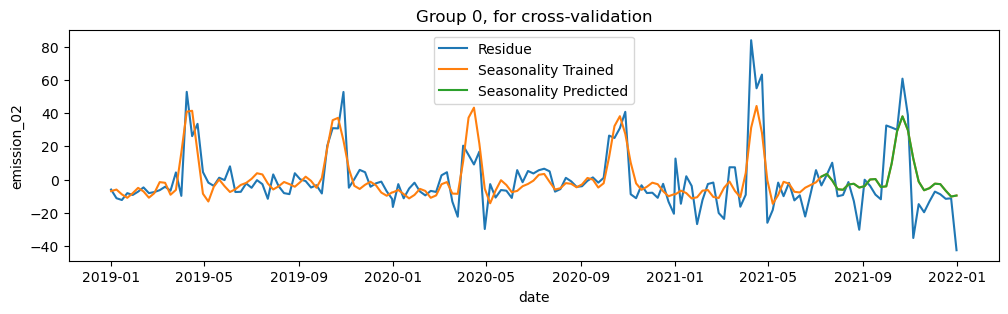

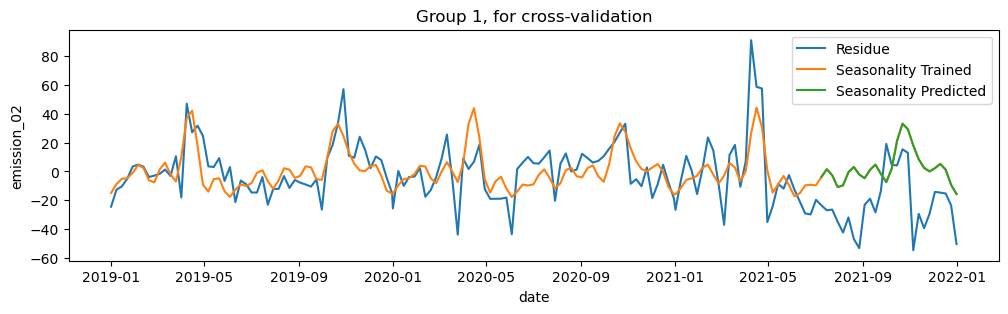

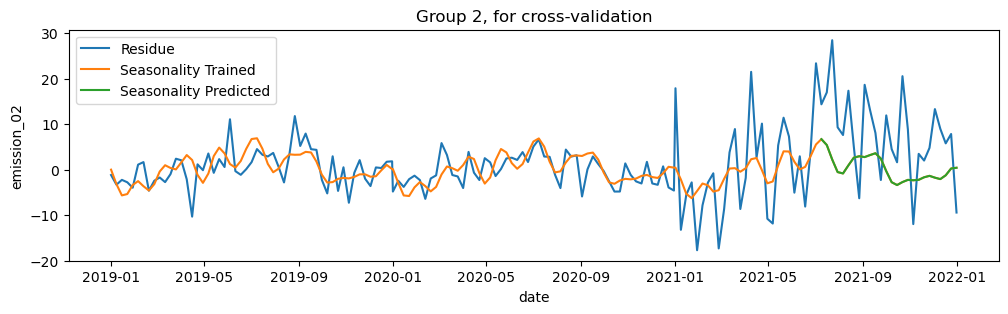

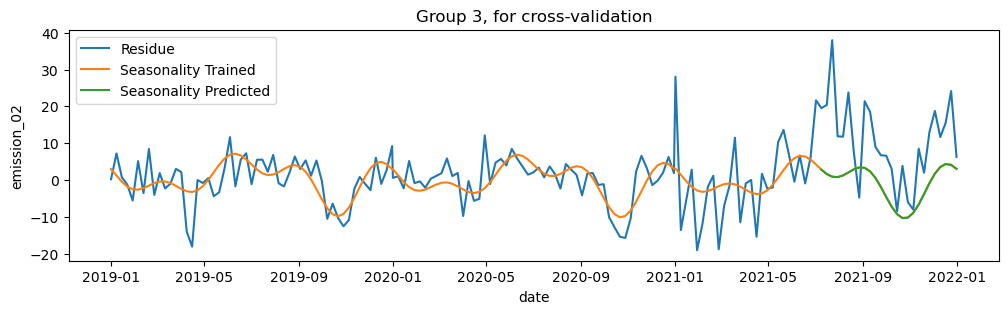

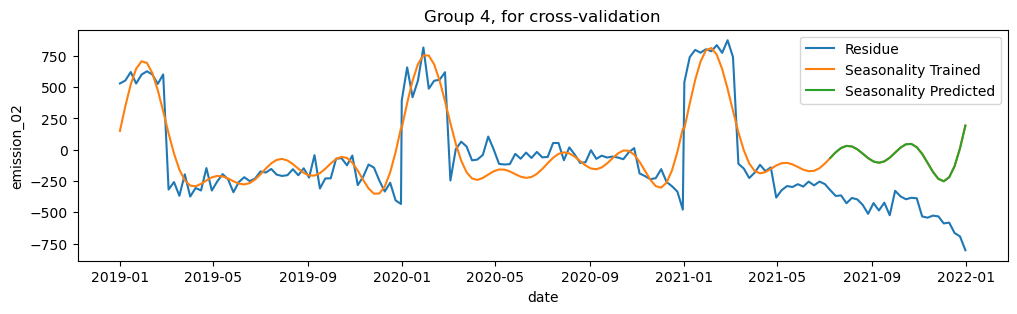

In [335]:
y_train_tuning_cv_technical = pd.concat([y_train, y_tuning, y_cv])

# Group by Group and date
y_train_tuning_cv_technical_grouped = y_train_tuning_cv_technical.groupby(['Group',
                                                                           'date']).agg(np.mean)
y_cv_grouped = y_cv.groupby(['Group', 'date']).agg(np.mean)

for group in groups:
    fig, ax = plt.subplots(figsize=(12, 3))
    
    sns.lineplot(data = y_train_tuning_cv_technical_grouped[y_train_tuning_cv_technical_grouped.\
                                                            index.get_level_values(\
                'Group') == group], x='date', y='emission_{}'.format('0' + str(int(study_number) -1)),
                 label='Residue').\
            set(title='Group {}, for cross-validation'.format(group))
    sns.lineplot(data = y_train_tuning_cv_technical_grouped[y_train_tuning_cv_technical_grouped.\
                                                            index.get_level_values(\
                'Group') == group], x='date', y='pred_{}'.format(study_number),
                 label='Seasonality Trained')
    sns.lineplot(data = y_cv_grouped[y_cv_grouped.index.get_level_values(\
                'Group') == group], x='date', y='pred_{}'.format(study_number),
                 label='Seasonality Predicted')

    plt.show()

In [336]:
pred_train = y_train['pred_01'] + y_train['pred_02'] + y_train['pred_03']
scores_df.loc[int(study_number), 'Train RMSE'] = mean_squared_error(y_train['emission'], 
                                            pred_train, squared=False)
pred_tuning = y_tuning['pred_01'] + y_tuning['pred_02'] + y_tuning['pred_03']
scores_df.loc[int(study_number), 'Tuning RMSE'] = mean_squared_error(y_tuning['emission'], 
                                            pred_tuning, squared=False)
pred_cv= y_cv['pred_01'] + y_cv['pred_02'] + y_cv['pred_03']
scores_df.loc[int(study_number), 'Cross-val RMSE'] = mean_squared_error(y_cv['emission'], 
                                            pred_cv, squared=False)
scores_df

Comment  Train RMSE  Tuning RMSE  Cross-val RMSE  Test RMSE
0      Satellite  118.798737   150.423002      140.329189        NaN
1        + tuned  117.365430   148.872404      139.874068   167.7199
2          Trend   38.582337    56.960628       52.020682        NaN
3  + Seasonality   25.994669    32.097991       46.747629        NaN

It worked. Now, let's calculate this for the whole data:

Group: 0


C:\Users\mikej\AppData\Local\Temp\ipykernel_10904\1382282885.py:5: FutureWarning: The operation <function mean at 0x00000213B3F76320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  y_train_tuning_cv_grouped = y_train_tuning_cv.groupby(['Group', 'date']).agg(np.mean)
C:\Users\mikej\My Drive\5\Kaggle\CO2-Emissions\functions\plot_periodogram.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1W")


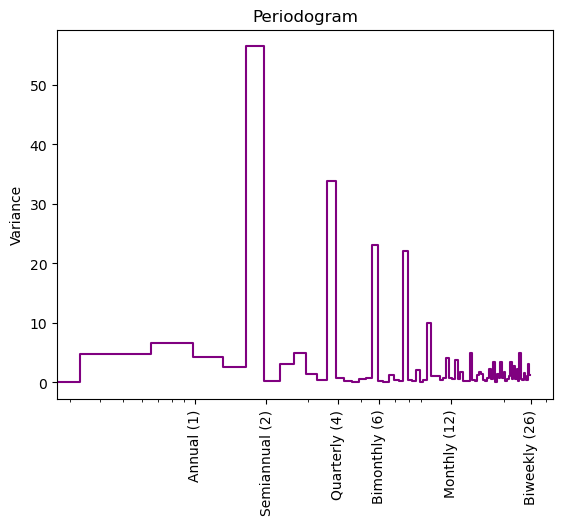

Group: 1


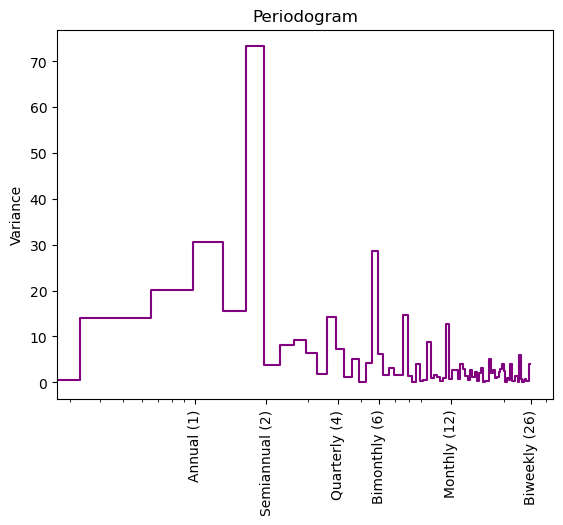

Group: 2


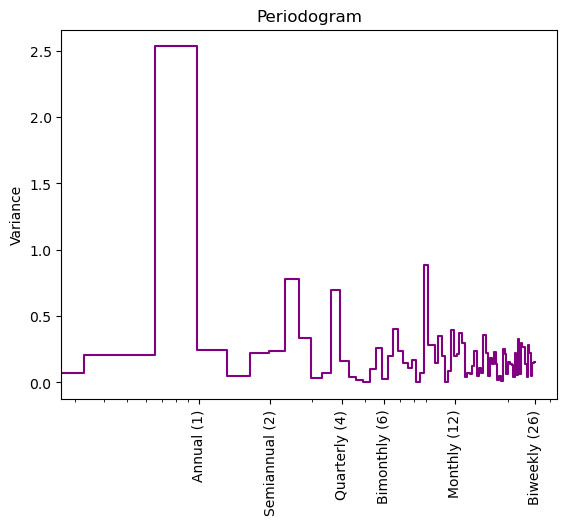

Group: 3


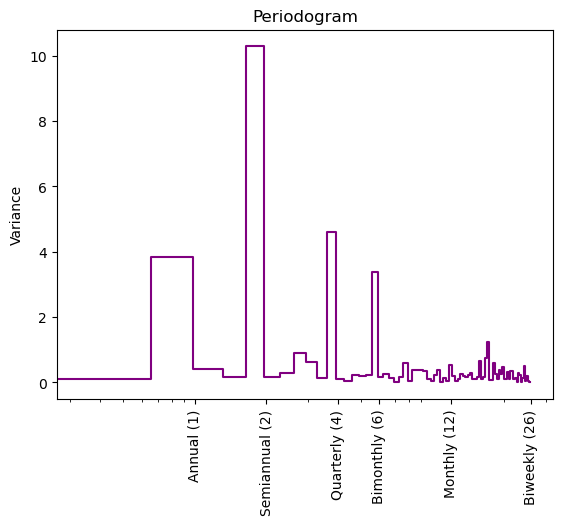

Group: 4


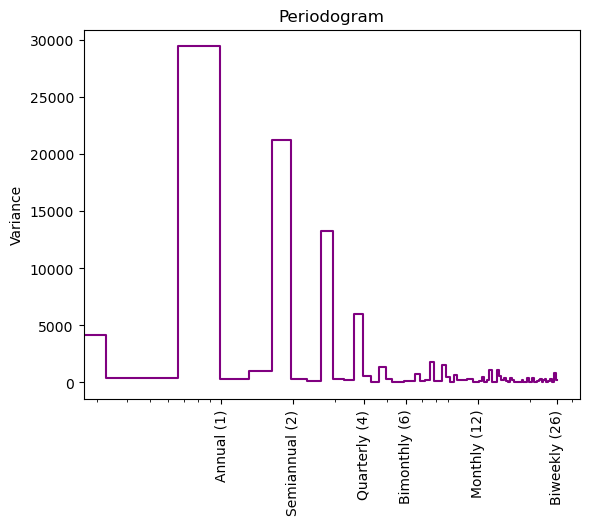

In [337]:
# FOR TESTING


# Group by Group and date
y_train_tuning_cv_grouped = y_train_tuning_cv.groupby(['Group', 'date']).agg(np.mean)

for group in groups:
    print('Group: ' + str(group))
    
    series = pd.Series(y_train_tuning_cv_grouped.loc[y_train_tuning_cv_grouped.\
                    index.get_level_values('Group') == group,
                    'emission_{}'.format('0' + str(int(study_number) -1))].values, \
                    index=y_train_tuning_cv_grouped.loc[y_train_tuning_cv_grouped.\
                    index.get_level_values('Group') == group].index.get_level_values('date'))  
        
    series.index = series.index.to_period('W')
    plot_periodogram(series)
    plt.show()

In [338]:
%%time

fourier_dict  = {0: 12, 1: 12, 2: 12, 3: 6, 4: 4}

locations_count=0

for location in y_train['Location'].unique():
    #Save indices
    train_tuning_cv_index = y_train_tuning_cv[y_train_tuning_cv['Location'] == location].index
    test_index = y_test[y_test['Location'] == location].index
    
    ## Create time series
    series = pd.Series(y_train_tuning_cv.loc[train_tuning_cv_index,
            'emission_{}'.format('0' + str(int(study_number) -1))].values, \
            index=y_train_tuning_cv.loc[train_tuning_cv_index, 'date'])
    
    series.index = series.index.to_period('W') 
    
    ## sin/cos pairs for annual seasonality
    pairs = fourier_dict[cluster_dictionary[location]]  
    fourier = CalendarFourier(freq="A", order=pairs)  
    
    # Set up DeterministicProcess
    dp = DeterministicProcess(index=series.index, constant=True,
        order=1,                     # trend (order 1 means linear)
        seasonal=False,               # indicators
        additional_terms=[fourier],  # annual seasonality
        drop=True,                   # drop terms to avoid collinearity
    )
    
    ## Calculate seasonality on the training + tuning + cv set
    
    # create features for dates in index
    X = dp.in_sample() 
    
    lr.fit(X, series)
    
    y_pred = pd.Series(lr.predict(X), index=train_tuning_cv_index)
    y_train_tuning_cv.loc[train_tuning_cv_index, 'pred_{}'.format(study_number)] = y_pred
    
    # Continue trend on the test set:
    
    X = dp.out_of_sample(steps=test_weeks)
    y_pred = pd.Series(lr.predict(X), index=test_index)
    y_test.loc[test_index, 'pred_{}'.format(study_number)] = y_pred

    locations_count +=1
    # print(locations_count)


CPU times: total: 39.7 s
Wall time: 10.5 s


C:\Users\mikej\AppData\Local\Temp\ipykernel_10904\2100430159.py:4: FutureWarning: The operation <function mean at 0x00000213B3F76320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  y_train_tuning_cv_test_grouped = y_train_tuning_cv_test.groupby(['Group', 'date']).agg(np.mean)
C:\Users\mikej\AppData\Local\Temp\ipykernel_10904\2100430159.py:5: FutureWarning: The operation <function mean at 0x00000213B3F76320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  y_test_grouped = y_test.groupby(['Group', 'date']).agg(np.mean)


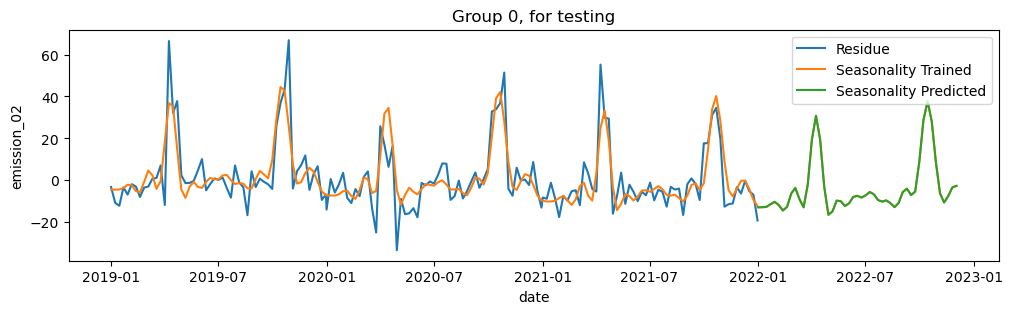

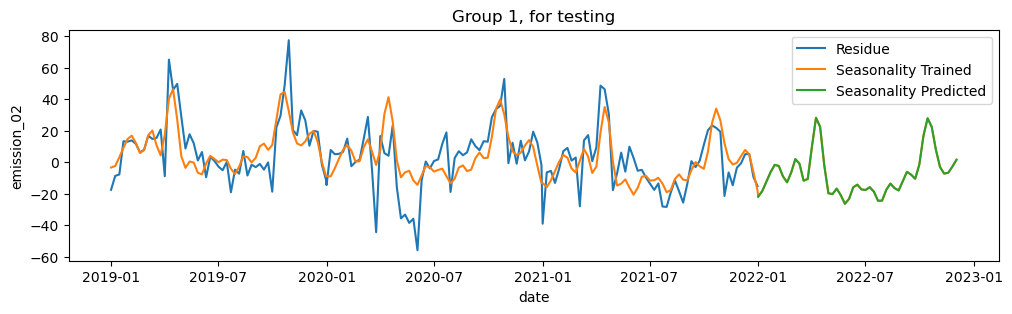

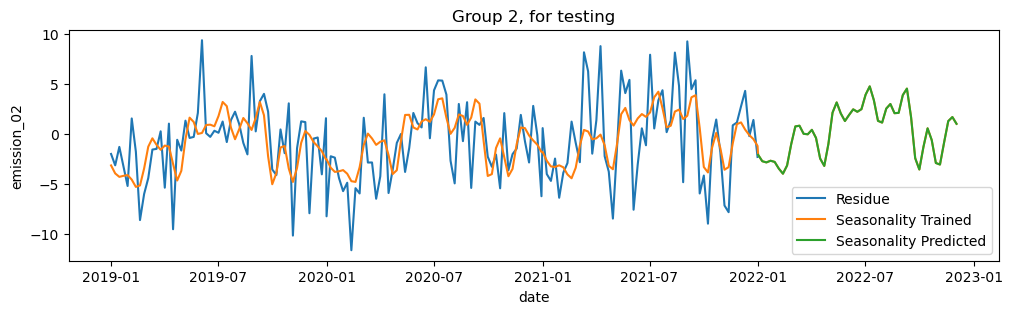

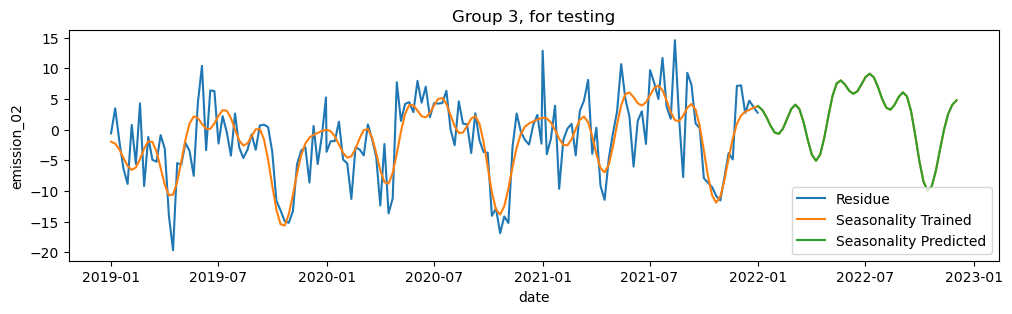

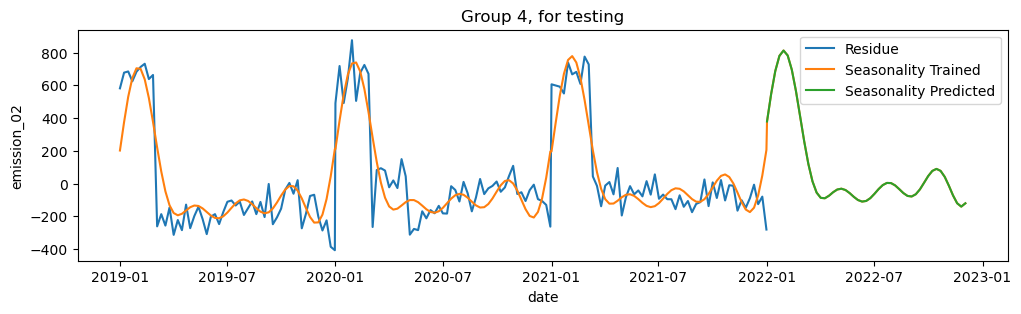

In [339]:
y_train_tuning_cv_test = pd.concat([y_train_tuning_cv, y_test])

# Group by Group and date
y_train_tuning_cv_test_grouped = y_train_tuning_cv_test.groupby(['Group', 'date']).agg(np.mean)
y_test_grouped = y_test.groupby(['Group', 'date']).agg(np.mean)

for group in groups:
    fig, ax = plt.subplots(figsize=(12, 3))
    
    sns.lineplot(data = y_train_tuning_cv_test_grouped[y_train_tuning_cv_test_grouped.\
                                                            index.get_level_values(\
                'Group') == group], x='date', y='emission_{}'.format('0' + str(int(study_number) -1)),
                 label='Residue').\
            set(title='Group {}, for testing'.format(group))
    sns.lineplot(data = y_train_tuning_cv_test_grouped[y_train_tuning_cv_test_grouped.\
                                                            index.get_level_values(\
                'Group') == group], x='date', y='pred_{}'.format(study_number),
                 label='Seasonality Trained')
    sns.lineplot(data = y_test_grouped[y_test_grouped.index.get_level_values(\
                'Group') == group], x='date', y='pred_{}'.format(study_number),
                 label='Seasonality Predicted')

    plt.show()

In [340]:
pred_test= y_test['pred_01'] + y_test['pred_02'] + y_test['pred_03']
# Create a submission file 
submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test.index, \
                           'emission': pred_test})

submission.to_csv('submissions/submission_4_' + study_number + '.csv', index=False)

In [341]:
scores_df.loc[int(study_number), 'Test RMSE'] = np.nan
scores_df

Comment  Train RMSE  Tuning RMSE  Cross-val RMSE  Test RMSE
0      Satellite  118.798737   150.423002      140.329189        NaN
1        + tuned  117.365430   148.872404      139.874068   167.7199
2          Trend   38.582337    56.960628       52.020682        NaN
3  + Seasonality   25.994669    32.097991       46.747629        NaN

In [342]:
y_train['emission_{}'.format(study_number)] = y_train['emission_{}'.\
        format('0' + str(int(study_number) -1))] - y_train['pred_{}'.format(study_number)]
y_tuning['emission_{}'.format(study_number)] = y_tuning['emission_{}'.\
        format('0' + str(int(study_number) -1))] - y_tuning['pred_{}'.format(study_number)]
y_cv['emission_{}'.format(study_number)] = y_cv['emission_{}'.\
        format('0' + str(int(study_number) -1))] - y_cv['pred_{}'.format(study_number)]
y_train_tuning_cv['emission_{}'.format(study_number)] = y_train_tuning_cv['emission_{}'.\
        format('0' + str(int(study_number) -1))] - y_train_tuning_cv['pred_{}'.format(study_number)]

## 04. Seasonality_2

Now, as in Part 2, let's perform a second round of deseasoning. For some groups we'll use annual seasonality again, for other we may use quarterly or monthly seasonality.

<timed exec>:12: FutureWarning: The operation <function mean at 0x00000213B3F76320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
C:\Users\mikej\My Drive\5\Kaggle\CO2-Emissions\functions\plot_periodogram.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1W")


Group: 0


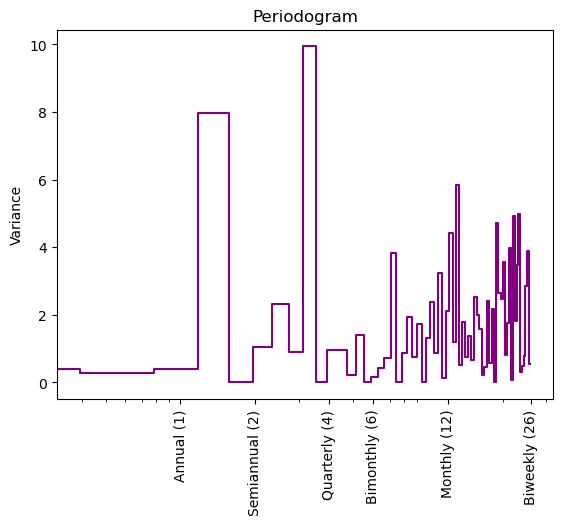

Group: 1


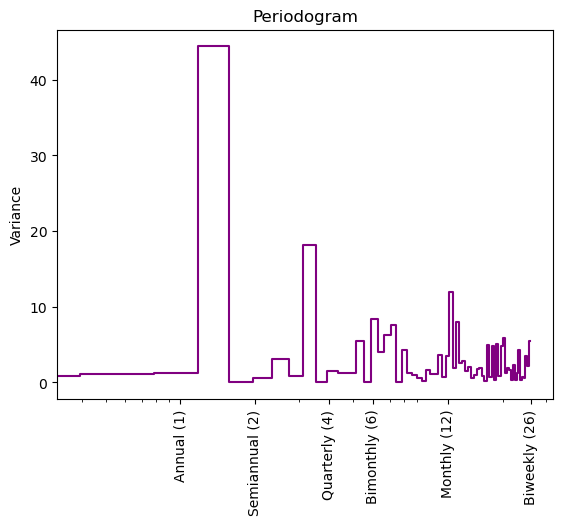

Group: 2


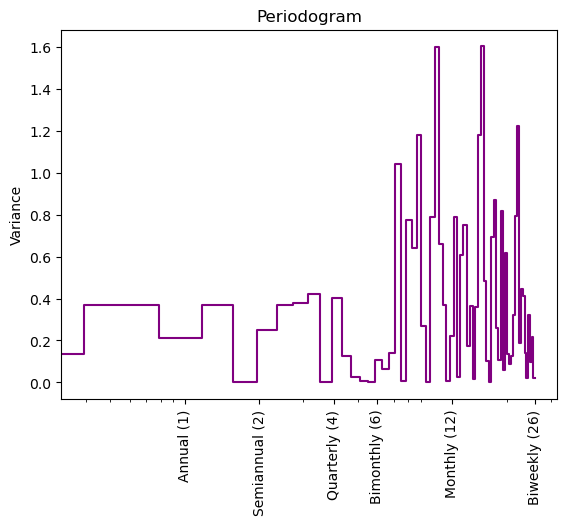

Group: 3


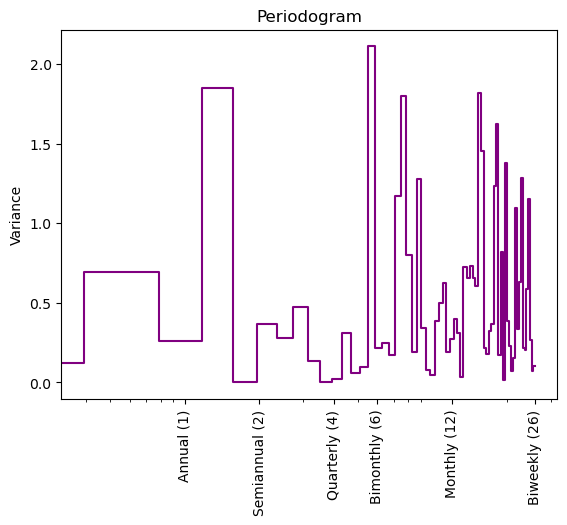

Group: 4


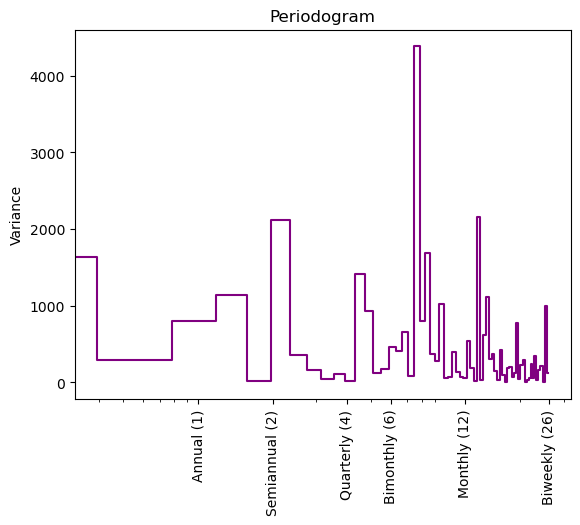

CPU times: total: 922 ms
Wall time: 1.1 s


In [343]:
%%time

study_number = '04'

scores_df.loc[int(study_number), 'Comment'] = '+ Seasonality_2'

from functions.plot_periodogram import plot_periodogram

#FOR CROSS-VALIDATION

y_train_tuning = pd.concat([y_train, y_tuning])

# Group by Group and date
y_train_tuning_grouped = y_train_tuning.groupby(['Group', 'date']).agg(np.mean)

for group in groups:
    print('Group: ' + str(group))
    
    series = pd.Series(y_train_tuning_grouped.loc[y_train_tuning_grouped.\
                    index.get_level_values('Group') == group,
                    'emission_{}'.format('0' + str(int(study_number) -1))].values, \
                    index=y_train_tuning_grouped.loc[y_train_tuning_grouped.\
                    index.get_level_values('Group') == group].index.get_level_values('date'))  
        
    series.index = series.index.to_period('W')
    plot_periodogram(series)
    plt.show()
    


In [344]:
%%time

fourier_dict  = {0: 4, 1: 4, 2: 6, 3: 9, 4: 9}
fourier_dict_periods = {0: 'A', 1: "A", 2: 'Q', 3: 'A', 4: 'A'}

locations_count=0

for location in y_train['Location'].unique():
    #Save indices
    train_tuning_index = y_train_tuning[y_train_tuning['Location'] == location].index
    train_index = y_train[y_train['Location'] == location].index
    tuning_index = y_tuning[y_tuning['Location'] == location].index
    cv_index = y_cv[y_cv['Location'] == location].index
    
    ## Create time series
    series = pd.Series(y_train_tuning.loc[train_tuning_index,
            'emission_{}'.format('0' + str(int(study_number) -1))].values, \
            index=y_train_tuning.loc[train_tuning_index, 'date'])
    
    series.index = series.index.to_period('W') 
    
    ## sin/cos pairs for annual seasonality
    pairs = fourier_dict[cluster_dictionary[location]]  
    fourier = CalendarFourier(freq=fourier_dict_periods[cluster_dictionary[location]] , order=pairs)  
    
    # Set up DeterministicProcess
    dp = DeterministicProcess(index=series.index, constant=True,
        order=1,                     # trend (order 1 means linear)
        seasonal=False,               # indicators
        additional_terms=[fourier],  # annual seasonality
        drop=True,                   # drop terms to avoid collinearity
    )
    
    ## Calculate seasonality on the training + tuning set
    
    # create features for dates in index
    X = dp.in_sample() 
    
    lr.fit(X, series)
    
    y_pred = pd.Series(lr.predict(X), index=train_tuning_index)
    y_train.loc[train_index, 'pred_{}'.format(study_number)] = y_pred[train_index]
    y_tuning.loc[tuning_index, 'pred_{}'.format(study_number)] = y_pred[tuning_index]
    
    # Continue trend on the cv set:
    X = dp.out_of_sample(steps=cv_weeks)
    y_pred = pd.Series(lr.predict(X), index=cv_index)
    y_cv.loc[cv_index, 'pred_{}'.format(study_number)] = y_pred

    locations_count +=1
    # print(locations_count)


CPU times: total: 47.5 s
Wall time: 12.4 s


C:\Users\mikej\AppData\Local\Temp\ipykernel_10904\2283749178.py:5: FutureWarning: The operation <function mean at 0x00000213B3F76320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  'date']).agg(np.mean)
C:\Users\mikej\AppData\Local\Temp\ipykernel_10904\2283749178.py:6: FutureWarning: The operation <function mean at 0x00000213B3F76320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  y_cv_grouped = y_cv.groupby(['Group', 'date']).agg(np.mean)


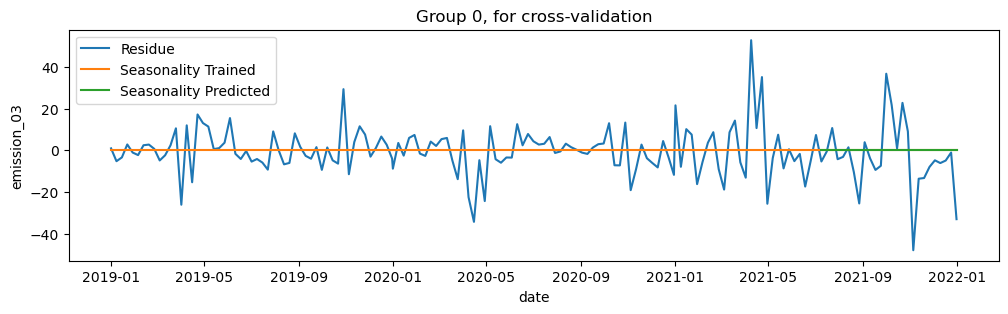

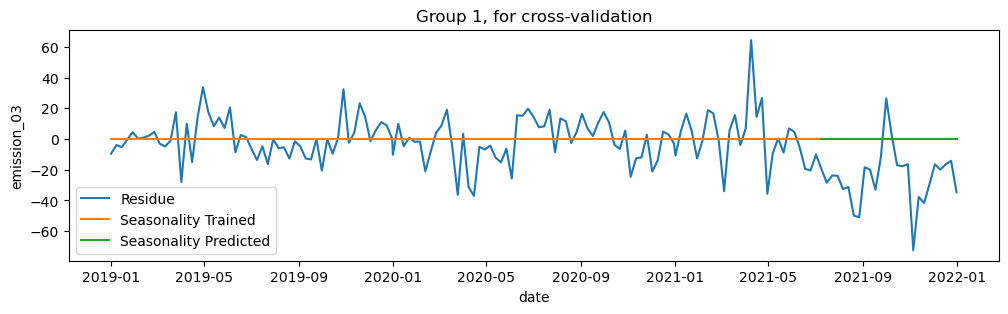

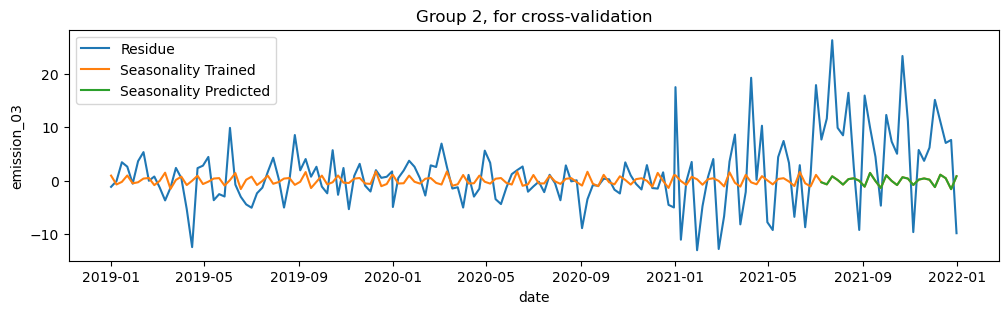

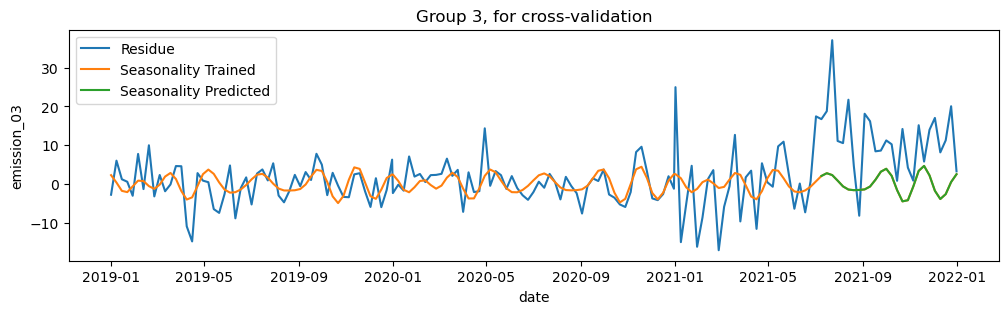

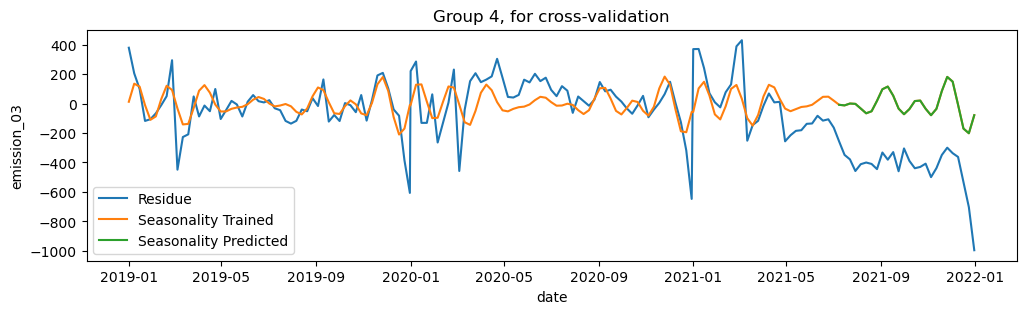

In [345]:
y_train_tuning_cv_technical = pd.concat([y_train, y_tuning, y_cv])

# Group by Group and date
y_train_tuning_cv_technical_grouped = y_train_tuning_cv_technical.groupby(['Group',
                                                                           'date']).agg(np.mean)
y_cv_grouped = y_cv.groupby(['Group', 'date']).agg(np.mean)

for group in groups:
    fig, ax = plt.subplots(figsize=(12, 3))
    
    sns.lineplot(data = y_train_tuning_cv_technical_grouped[y_train_tuning_cv_technical_grouped.\
                                                            index.get_level_values(\
                'Group') == group], x='date', y='emission_{}'.format('0' + str(int(study_number) -1)),
                 label='Residue').\
            set(title='Group {}, for cross-validation'.format(group))
    sns.lineplot(data = y_train_tuning_cv_technical_grouped[y_train_tuning_cv_technical_grouped.\
                                                            index.get_level_values(\
                'Group') == group], x='date', y='pred_{}'.format(study_number),
                 label='Seasonality Trained')
    sns.lineplot(data = y_cv_grouped[y_cv_grouped.index.get_level_values(\
                'Group') == group], x='date', y='pred_{}'.format(study_number),
                 label='Seasonality Predicted')

    plt.show()

In [346]:
pred_train = y_train['pred_01'] + y_train['pred_02'] + y_train['pred_03'] + y_train['pred_04']
scores_df.loc[int(study_number), 'Train RMSE'] = mean_squared_error(y_train['emission'], 
                                            pred_train, squared=False)
pred_tuning = y_tuning['pred_01'] + y_tuning['pred_02'] + y_tuning['pred_03'] + y_tuning['pred_04']
scores_df.loc[int(study_number), 'Tuning RMSE'] = mean_squared_error(y_tuning['emission'], 
                                            pred_tuning, squared=False)
pred_cv= y_cv['pred_01'] + y_cv['pred_02'] + y_cv['pred_03'] + y_cv['pred_04']
scores_df.loc[int(study_number), 'Cross-val RMSE'] = mean_squared_error(y_cv['emission'], 
                                            pred_cv, squared=False)
scores_df

Comment  Train RMSE  Tuning RMSE  Cross-val RMSE  Test RMSE
0        Satellite  118.798737   150.423002      140.329189        NaN
1          + tuned  117.365430   148.872404      139.874068   167.7199
2            Trend   38.582337    56.960628       52.020682        NaN
3    + Seasonality   25.994669    32.097991       46.747629        NaN
4  + Seasonality_2   24.833018    30.323204       46.162588        NaN

Group: 0


C:\Users\mikej\AppData\Local\Temp\ipykernel_10904\1382282885.py:5: FutureWarning: The operation <function mean at 0x00000213B3F76320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  y_train_tuning_cv_grouped = y_train_tuning_cv.groupby(['Group', 'date']).agg(np.mean)
C:\Users\mikej\My Drive\5\Kaggle\CO2-Emissions\functions\plot_periodogram.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1W")


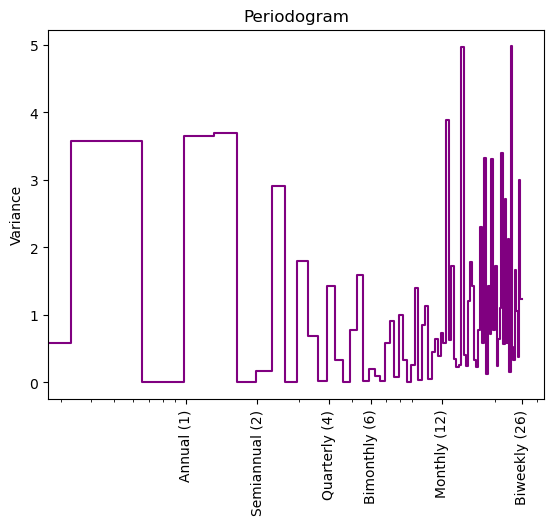

Group: 1


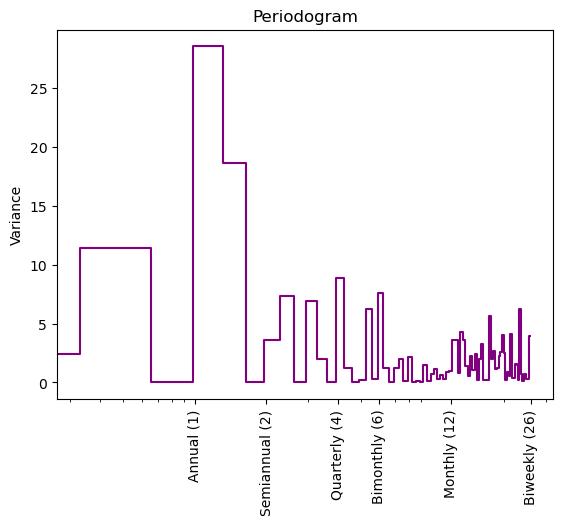

Group: 2


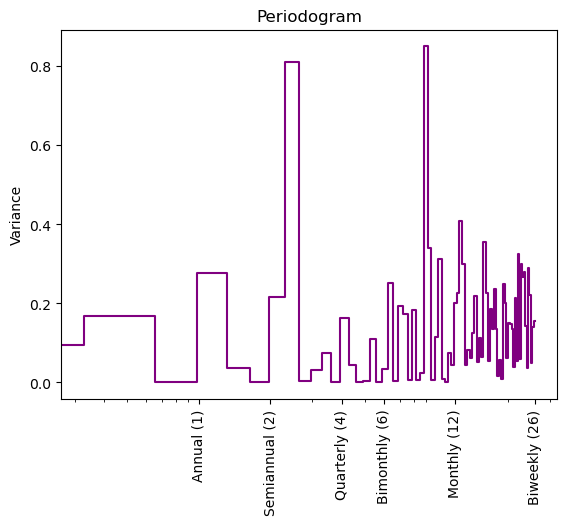

Group: 3


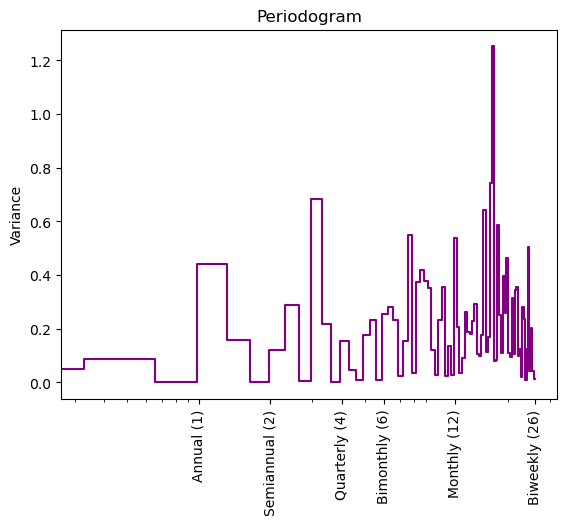

Group: 4


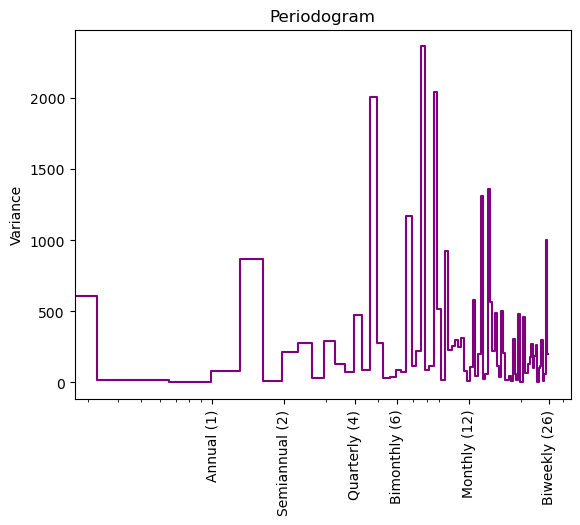

In [347]:
# FOR TESTING


# Group by Group and date
y_train_tuning_cv_grouped = y_train_tuning_cv.groupby(['Group', 'date']).agg(np.mean)

for group in groups:
    print('Group: ' + str(group))
    
    series = pd.Series(y_train_tuning_cv_grouped.loc[y_train_tuning_cv_grouped.\
                    index.get_level_values('Group') == group,
                    'emission_{}'.format('0' + str(int(study_number) -1))].values, \
                    index=y_train_tuning_cv_grouped.loc[y_train_tuning_cv_grouped.\
                    index.get_level_values('Group') == group].index.get_level_values('date'))  
        
    series.index = series.index.to_period('W')
    plot_periodogram(series)
    plt.show()

In [348]:
%%time

fourier_dict  = {0: 6, 1: 2, 2: 3, 3: 4, 4: 3}
fourier_dict_periods = {0: 'A', 1: "A", 2: 'A', 3: 'A', 4: 'Q'}


locations_count=0

for location in y_train['Location'].unique():
    #Save indices
    train_tuning_cv_index = y_train_tuning_cv[y_train_tuning_cv['Location'] == location].index
    test_index = y_test[y_test['Location'] == location].index
    
    ## Create time series
    series = pd.Series(y_train_tuning_cv.loc[train_tuning_cv_index,
            'emission_{}'.format('0' + str(int(study_number) -1))].values, \
            index=y_train_tuning_cv.loc[train_tuning_cv_index, 'date'])
    
    series.index = series.index.to_period('W') 
    
    ## sin/cos pairs for annual seasonality
    pairs = fourier_dict[cluster_dictionary[location]]  
    fourier = CalendarFourier(freq=fourier_dict_periods[cluster_dictionary[location]] , order=pairs)  
    
    # Set up DeterministicProcess
    dp = DeterministicProcess(index=series.index, constant=True,
        order=1,                     # trend (order 1 means linear)
        seasonal=False,               # indicators
        additional_terms=[fourier],  # annual seasonality
        drop=True,                   # drop terms to avoid collinearity
    )
    
    ## Calculate seasonality on the training + tuning + cv set
    
    # create features for dates in index
    X = dp.in_sample() 
    
    lr.fit(X, series)
    
    y_pred = pd.Series(lr.predict(X), index=train_tuning_cv_index)
    y_train_tuning_cv.loc[train_tuning_cv_index, 'pred_{}'.format(study_number)] = y_pred
    
    # Continue trend on the test set:
    
    X = dp.out_of_sample(steps=test_weeks)
    y_pred = pd.Series(lr.predict(X), index=test_index)
    y_test.loc[test_index, 'pred_{}'.format(study_number)] = y_pred

    locations_count +=1
    # print(locations_count)


CPU times: total: 38.1 s
Wall time: 9.84 s


C:\Users\mikej\AppData\Local\Temp\ipykernel_10904\2100430159.py:4: FutureWarning: The operation <function mean at 0x00000213B3F76320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  y_train_tuning_cv_test_grouped = y_train_tuning_cv_test.groupby(['Group', 'date']).agg(np.mean)
C:\Users\mikej\AppData\Local\Temp\ipykernel_10904\2100430159.py:5: FutureWarning: The operation <function mean at 0x00000213B3F76320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  y_test_grouped = y_test.groupby(['Group', 'date']).agg(np.mean)


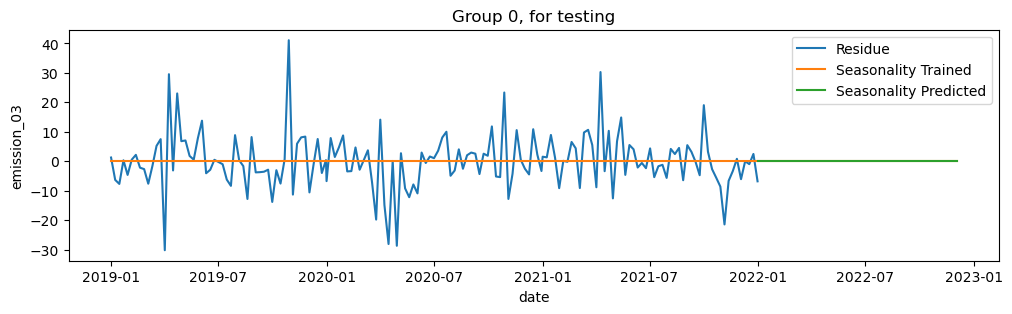

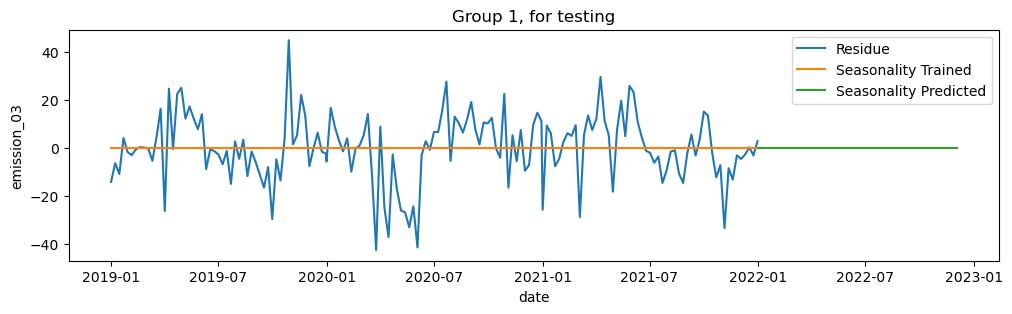

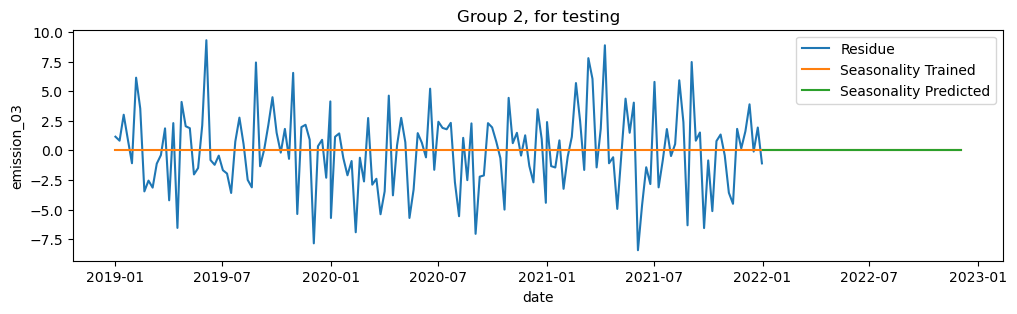

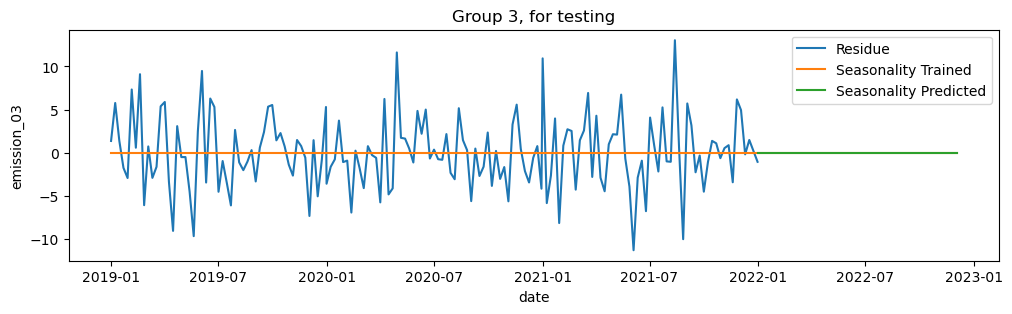

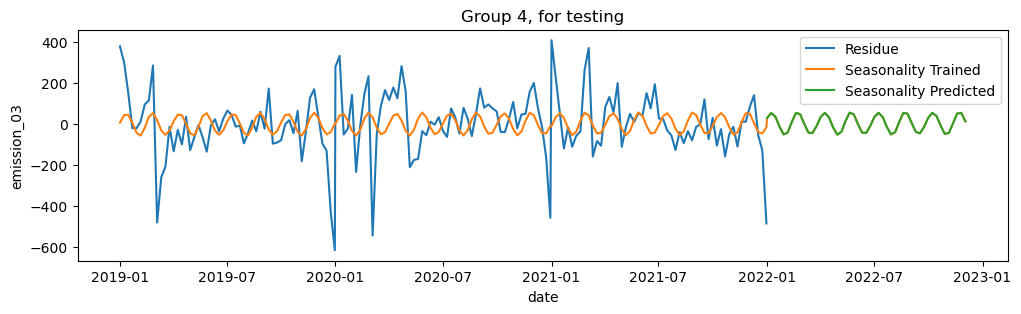

In [349]:
y_train_tuning_cv_test = pd.concat([y_train_tuning_cv, y_test])

# Group by Group and date
y_train_tuning_cv_test_grouped = y_train_tuning_cv_test.groupby(['Group', 'date']).agg(np.mean)
y_test_grouped = y_test.groupby(['Group', 'date']).agg(np.mean)

for group in groups:
    fig, ax = plt.subplots(figsize=(12, 3))
    
    sns.lineplot(data = y_train_tuning_cv_test_grouped[y_train_tuning_cv_test_grouped.\
                                                            index.get_level_values(\
                'Group') == group], x='date', y='emission_{}'.format('0' + str(int(study_number) -1)),
                 label='Residue').\
            set(title='Group {}, for testing'.format(group))
    sns.lineplot(data = y_train_tuning_cv_test_grouped[y_train_tuning_cv_test_grouped.\
                                                            index.get_level_values(\
                'Group') == group], x='date', y='pred_{}'.format(study_number),
                 label='Seasonality Trained')
    sns.lineplot(data = y_test_grouped[y_test_grouped.index.get_level_values(\
                'Group') == group], x='date', y='pred_{}'.format(study_number),
                 label='Seasonality Predicted')

    plt.show()

In [350]:
pred_test= y_test['pred_01'] + y_test['pred_02'] + y_test['pred_03'] + y_test['pred_04']
# Create a submission file 
submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test.index, \
                           'emission': pred_test})

submission.to_csv('submissions/submission_4_' + study_number + '.csv', index=False)

In [351]:
scores_df.loc[int(study_number), 'Test RMSE'] = 49.39932
scores_df

Comment  Train RMSE  Tuning RMSE  Cross-val RMSE  Test RMSE
0        Satellite  118.798737   150.423002      140.329189        NaN
1          + tuned  117.365430   148.872404      139.874068  167.71990
2            Trend   38.582337    56.960628       52.020682        NaN
3    + Seasonality   25.994669    32.097991       46.747629        NaN
4  + Seasonality_2   24.833018    30.323204       46.162588   49.39932

In [352]:
y_train['emission_{}'.format(study_number)] = y_train['emission_{}'.\
        format('0' + str(int(study_number) -1))] - y_train['pred_{}'.format(study_number)]
y_tuning['emission_{}'.format(study_number)] = y_tuning['emission_{}'.\
        format('0' + str(int(study_number) -1))] - y_tuning['pred_{}'.format(study_number)]
y_cv['emission_{}'.format(study_number)] = y_cv['emission_{}'.\
        format('0' + str(int(study_number) -1))] - y_cv['pred_{}'.format(study_number)]
y_train_tuning_cv['emission_{}'.format(study_number)] = y_train_tuning_cv['emission_{}'.\
        format('0' + str(int(study_number) -1))] - y_train_tuning_cv['pred_{}'.format(study_number)]

## 05. Cycles

Now, let's explore cycles. We'll use a few functions by Ryan Holbrook.

<timed exec>:68: FutureWarning: The operation <function mean at 0x00000213B3F76320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Group: 0


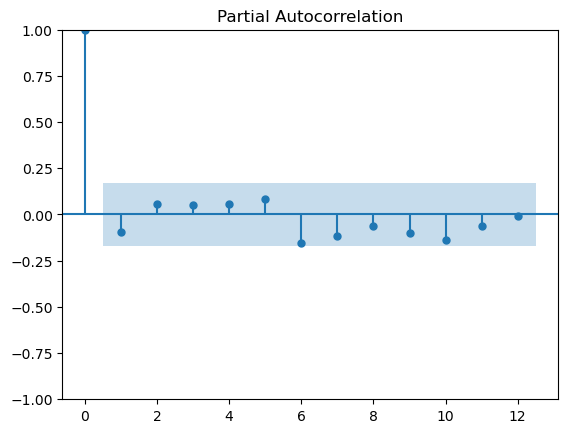

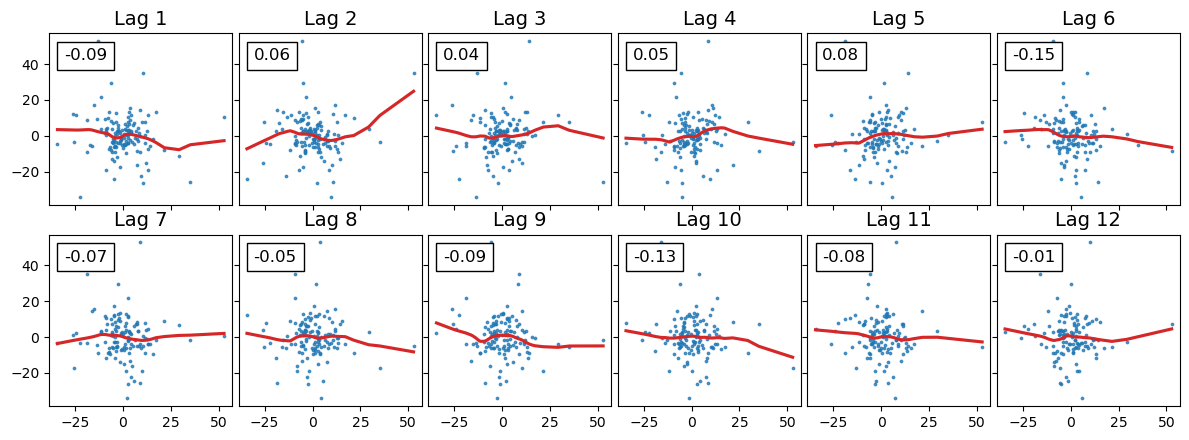

Group: 1


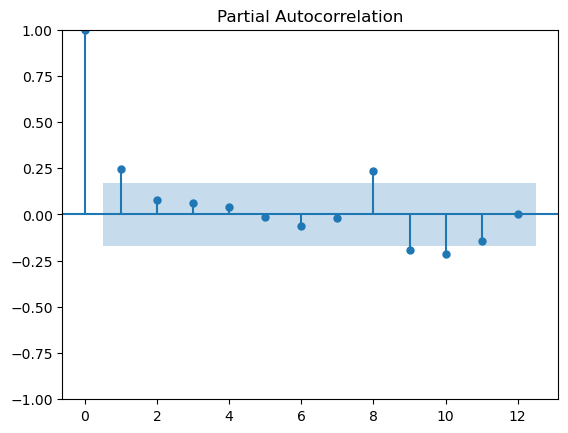

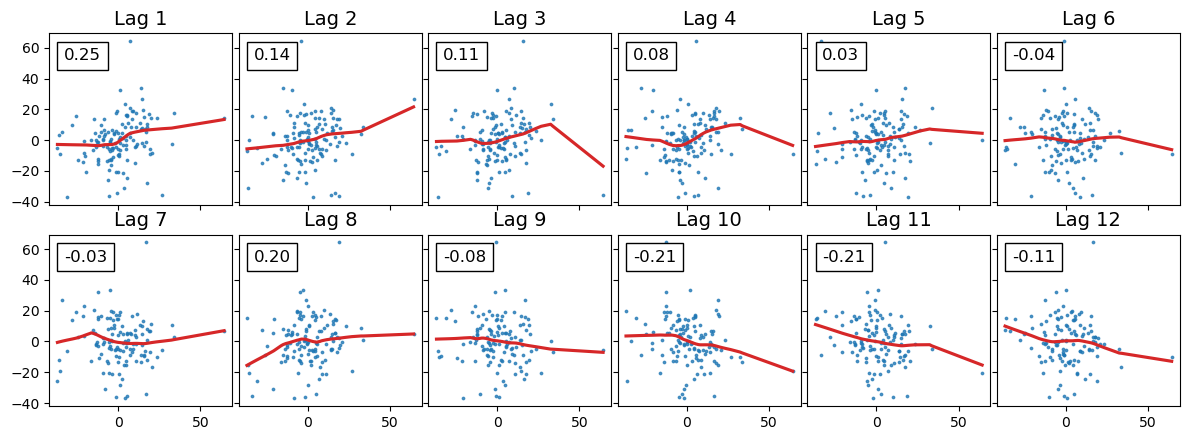

Group: 2


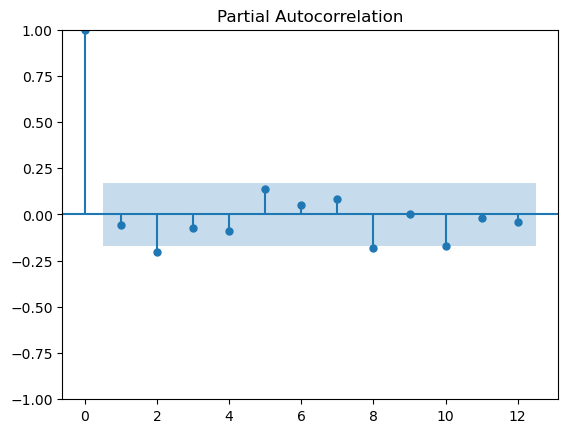

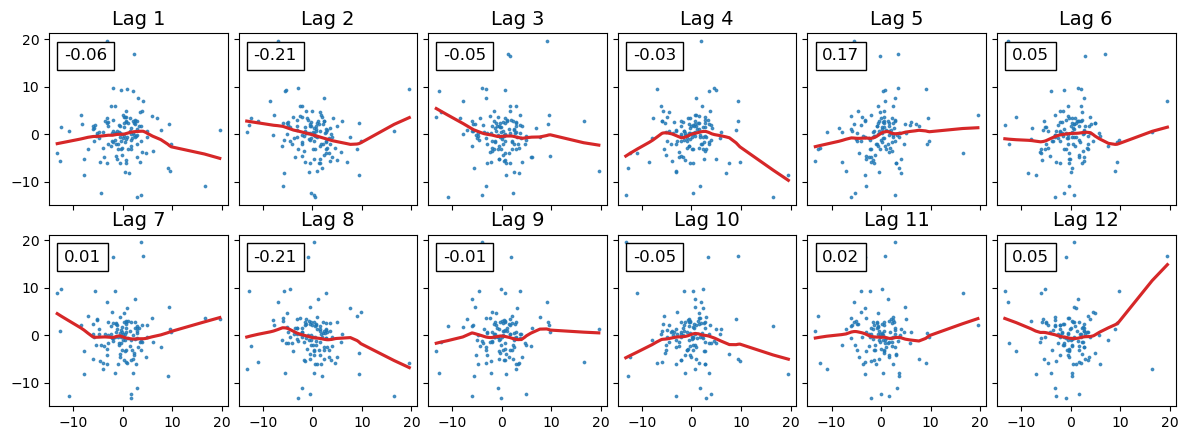

Group: 3


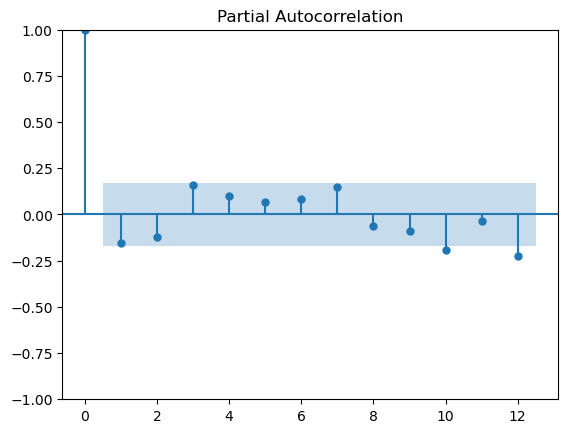

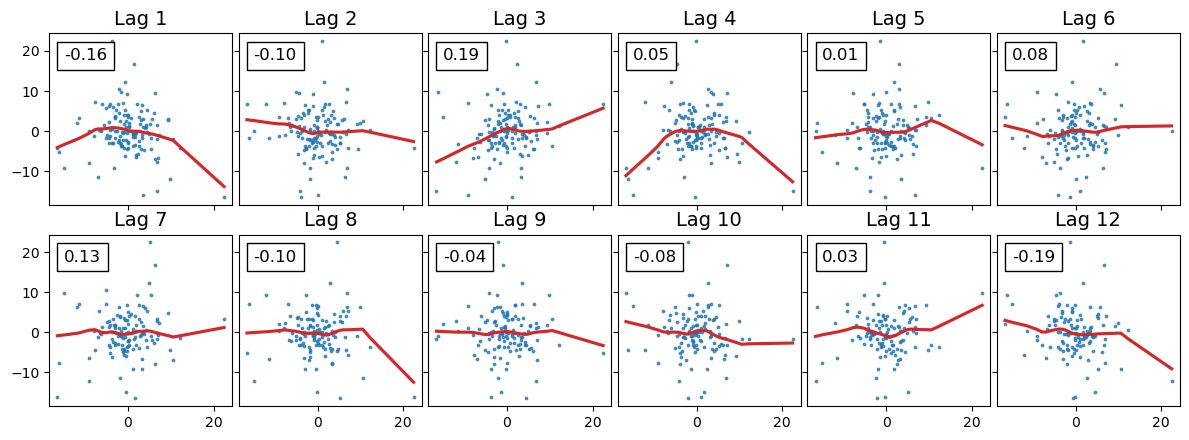

Group: 4


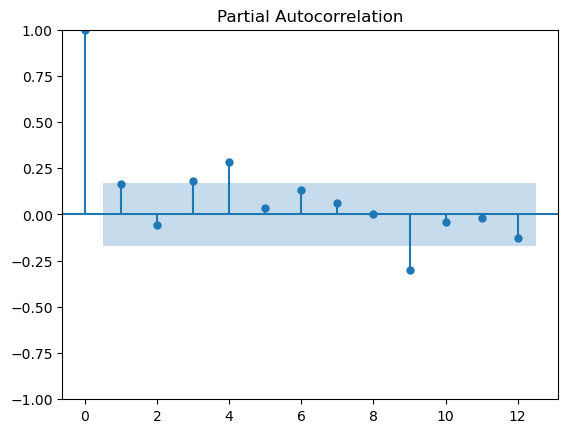

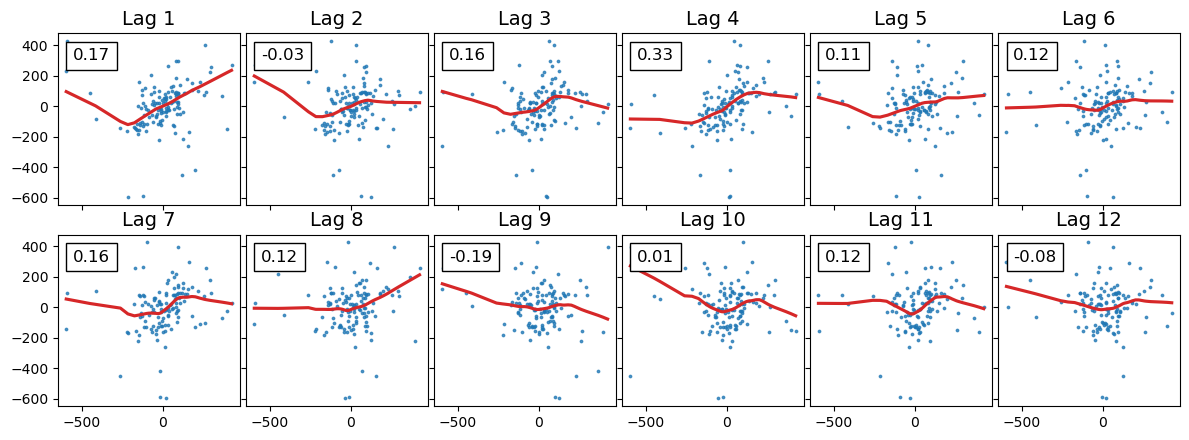

CPU times: total: 7.75 s
Wall time: 8.5 s


In [353]:
%%time

study_number = '05'

scores_df.loc[int(study_number), 'Comment'] = '+ Cycles'

from statsmodels.graphics.tsaplots import plot_pacf

def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

LAGS = 6 * 2

## FOR CROSS-VALIDATION

y_train_tuning = pd.concat([y_train, y_tuning])

# Group by Group and date
y_train_tuning_grouped = y_train_tuning.groupby(['Group', 'date']).agg(np.mean)

for group in groups:
    print('Group: ' + str(group))
    
    series = pd.Series(y_train_tuning_grouped.loc[y_train_tuning_grouped.\
                    index.get_level_values('Group') == group,
                    'emission_{}'.format('0' + str(int(study_number) -1))].values, \
                    index=y_train_tuning_grouped.loc[y_train_tuning_grouped.\
                    index.get_level_values('Group') == group].index.get_level_values('date'))  
        
    _ = plot_pacf(series, lags=LAGS)
    _ = plot_lags(series, lags=LAGS, nrows= round(LAGS / 6))
    plt.show()


Here, only Group 4 is worthy of decycling, with lag of 4 weeks:

In [354]:
%%time



# Extract locations in Group 4
group_4 = [k for k,v in cluster_dictionary.items() if v == 4]

# For each location
for location in group_4:

    # Calculate lag_1
    
    y_train_tuning.loc[y_train_tuning['Location'] == location, 'emission_04_lag_4'] = \
                y_train_tuning.loc[y_train_tuning['Location'] == location, 'emission_04'].shift(4)
    
    # Fill missing lags with 0's
    y_train_tuning.loc[(y_train_tuning['Location'] == location) &
                        (y_train_tuning['emission_04_lag_1'].isna()), 'emission_04_lag_1'] = 0

y_train_tuning.loc[y_train_tuning['Location'].isin(group_4)].head()

KeyError: 'emission_04_lag_1'

In [355]:
%%time

from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb

def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)

model = MultiOutputRegressor(xgb.XGBRegressor(random_state=SEED, n_jobs=-1, n_estimators=100))

def cycles_forecast(y_train_and_test, y_train, y_test,
                    train_and_test_locations, train_locations, test_locations):
    location_count = 0
    # For each location
    for location in group_4:

        train_and_test_index = train_and_test_locations == location
        train_index = train_locations == location
        test_index = test_locations == location

        ## Set up the lags DataFrame 
        emission_lags_train = \
                pd.DataFrame(y_train.loc[train_index, 'emission_04_lag_4'])

        # Make multistep target
        y = pd.Series(y_train.loc[train_index, 'emission_04'])
        y = make_multistep_target(y, steps=sum(test_index)).dropna()

        #print(y)

        # Only keep weeks for which we have both targets and features.
        y, X = y.align(emission_lags_train, join='inner', axis=0)

        # Fit
        model.fit(X, y)

        ## Create predictions

        # Create prediction matrix
        pred_matrix = pd.DataFrame(model.predict(emission_lags_train),
                                   index=y_train[train_index].index,
                                   columns=y.columns)
        # print(pred_matrix.info())

        # Add empty rows
        empty_matrix = pd.DataFrame(index=y_test[test_index].index, columns=y.columns)
        pred_matrix = pd.concat([pred_matrix, empty_matrix])

        # print(pred_matrix)

        # Shift predictions to align with dates
        pred_matrix_shifted = pd.DataFrame(index=y_train_and_test[train_and_test_index].index)
        for i in range(sum(test_index)):
            pred_matrix_shifted[i + 1] = pred_matrix.iloc[:, i].shift(i + 1)

        #print(pred_matrix_shifted)
        # Calculate mean predictions
        predictions = pred_matrix_shifted.mean(axis=1)
        # Fill missing values
        predictions.fillna(0, inplace=True)

        # Add values to sets
        y_train.loc[train_index, 'pred_05'] = \
            predictions[:sum(train_index)]
        y_test.loc[test_index, 'pred_05'] = predictions[sum(train_index):]

        assert (y_train.loc[train_index, 'pred_05'].isna().any() == False)
        assert (y_test.loc[test_index, 'pred_05'].isna().any() == False)

        location_count +=1
        # print(location_count)

    return y_train, y_test

y_train_tuning_cv_technical = pd.concat([y_train, y_tuning, y_cv])

y_train_tuning, y_cv = cycles_forecast(y_train_tuning_cv_technical, y_train_tuning, y_cv,
                                      y_train_tuning_cv_technical['Location'],
                                      y_train_tuning['Location'],
                                      y_cv['Location'])

CPU times: total: 16.1 s
Wall time: 1.63 s


C:\Users\mikej\AppData\Local\Temp\ipykernel_10904\788586311.py:5: FutureWarning: The operation <function mean at 0x00000213B3F76320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  'date']).agg(np.mean)
C:\Users\mikej\AppData\Local\Temp\ipykernel_10904\788586311.py:6: FutureWarning: The operation <function mean at 0x00000213B3F76320> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  y_cv_grouped = y_cv.groupby(['Group', 'date']).agg(np.mean)


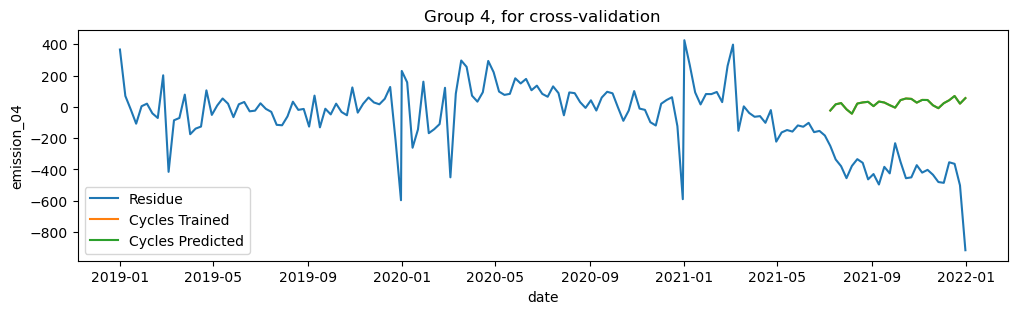

In [356]:
y_train_tuning_cv_technical = pd.concat([y_train, y_tuning, y_cv])

# Group by Group and date
y_train_tuning_cv_technical_grouped = y_train_tuning_cv_technical.groupby(['Group',
                                                                           'date']).agg(np.mean)
y_cv_grouped = y_cv.groupby(['Group', 'date']).agg(np.mean)


fig, ax = plt.subplots(figsize=(12, 3))

sns.lineplot(data = y_train_tuning_cv_technical_grouped[y_train_tuning_cv_technical_grouped.\
                                                        index.get_level_values(\
            'Group') == 4], x='date', y='emission_{}'.format('0' + str(int(study_number) -1)),
             label='Residue').\
        set(title='Group {}, for cross-validation'.format(4))
sns.lineplot(data = y_train_tuning_cv_technical_grouped[y_train_tuning_cv_technical_grouped.\
                                                        index.get_level_values(\
            'Group') == 4], x='date', y='pred_{}'.format(study_number),
             label='Cycles Trained')
sns.lineplot(data = y_cv_grouped[y_cv_grouped.index.get_level_values(\
            'Group') == 4], x='date', y='pred_{}'.format(study_number),
             label='Cycles Predicted')

plt.show()

In [357]:
%%time

## Fill the values
y_train['pred_05'] = 0
y_train.loc[y_train['Group'] == 4, 'pred_05'] = \
                                    y_train_tuning.loc[y_train[y_train['Group'] == 4].index,
                                                               'pred_05']
y_tuning['pred_05'] = 0
y_tuning.loc[y_tuning['Group'] == 4, 'pred_05'] = \
                                    y_train_tuning.loc[y_tuning[y_tuning['Group'] == 4].index,
                                                               'pred_05']
y_cv.loc[y_cv['pred_05'].isna(), 'pred_05'] = 0

## Calculate scores

pred_train = y_train['pred_01'] + y_train['pred_02'] + y_train['pred_03'] + y_train['pred_04'] +\
             y_train['pred_05']
scores_df.loc[int(study_number), 'Train RMSE'] = mean_squared_error(y_train['emission'], 
                                            pred_train, squared=False)
pred_tuning = y_tuning['pred_01'] + y_tuning['pred_02'] + y_tuning['pred_03'] + y_tuning['pred_04'] +\
              y_tuning['pred_05']
scores_df.loc[int(study_number), 'Tuning RMSE'] = mean_squared_error(y_tuning['emission'], 
                                            pred_tuning, squared=False)
pred_cv= y_cv['pred_01'] + y_cv['pred_02'] + y_cv['pred_03'] + y_cv['pred_04'] +\
         y_cv['pred_05']
scores_df.loc[int(study_number), 'Cross-val RMSE'] = mean_squared_error(y_cv['emission'], 
                                            pred_cv, squared=False)
scores_df

CPU times: total: 15.6 ms
Wall time: 21.3 ms


Comment  Train RMSE  Tuning RMSE  Cross-val RMSE  Test RMSE
0        Satellite  118.798737   150.423002      140.329189        NaN
1          + tuned  117.365430   148.872404      139.874068  167.71990
2            Trend   38.582337    56.960628       52.020682        NaN
3    + Seasonality   25.994669    32.097991       46.747629        NaN
4  + Seasonality_2   24.833018    30.323204       46.162588   49.39932
5         + Cycles   25.458623    33.300131       47.628945        NaN

The cross-val RMSE went up, so we won't use decycling.

Now we can compare the strategy in Part 4 with a similar strategy in Part 2, and conclude that the Part 2 strategy worked better (the Test Score is lower). Therefore, it is not worthwhile to continue with Part 4.